## Pre-preparation

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#For auto ARIMA
# Install a pip package in the current Jupyter kernel
import sys
import importlib.util

# For illustrative purposes.
package_name = 'pmdarima'

spec = importlib.util.find_spec(package_name)
if spec is None:
 !{sys.executable} -m pip install pmdarima --user

#Altenative way of installation
#!pip install pmdarima --user
import pmdarima as pm

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [4]:
data = pd.read_csv('all_trends.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True) 

## Data Exploratory Analysis 

In [5]:
keyword = np.unique(data['keyword']) #select data based on keyword 
keyword

array(['5SOS', 'Blackpink', 'Business Analytics', 'COVID', 'ChatGPT',
       'Lazarbeam', 'MrBeast', 'University of New South Wales',
       'University of Sydney', 'fresh', 'lachlan', 'loserfruit'],
      dtype=object)

In [6]:
frequency = []
for i in keyword : 
    freq = pd.infer_freq(data.loc[data['keyword'] == i].index)
    frequency.append(freq)

frequency = pd.DataFrame(frequency, columns=['Freq'], index=keyword)
frequency

Freq
5SOS                           W-SUN
Blackpink                          H
Business Analytics             W-SUN
COVID                          W-SUN
ChatGPT                            D
Lazarbeam                      W-SUN
MrBeast                        W-SUN
University of New South Wales  W-SUN
University of Sydney           W-SUN
fresh                          W-SUN
lachlan                        W-SUN
loserfruit                     W-SUN

In [7]:
#number of observations in test set and training set for each time series
total = []
test = []
train = []
for i in keyword : 
    n = data.loc[data['keyword'] == i, 'hits'].count() 
    total.append(n)
    t = int(np.ceil(n*0.1)) #round up for test set
    test.append(t)
    tr = n - t
    train.append(tr)

columns=['Total Obs', 'Test Obs', 'Train Obs']
observations = np.vstack([total,test,train]).T
observations = pd.DataFrame(observations, columns=columns, index=keyword)
observations

Total Obs  Test Obs  Train Obs
5SOS                                  52         6         46
Blackpink                            481        49        432
Business Analytics                   261        27        234
COVID                                156        16        140
ChatGPT                               86         9         77
Lazarbeam                             52         6         46
MrBeast                               52         6         46
University of New South Wales        261        27        234
University of Sydney                 261        27        234
fresh                                 52         6         46
lachlan                               52         6         46
loserfruit                            52         6         46

In [8]:
#plot of each series
def plot(keyword):
    n = data.loc[data['keyword'] == keyword, 'hits'].count() 
    y = data.loc[data['keyword'] == keyword, 'hits'].head(-int(np.ceil(n*0.1))) #training set
    fig, ax= plt.subplots(figsize=(10,4))
    plt.plot(y.index, y, color=red)
    ax.set_xlabel('Date')
    ax.set_ylabel("Hits")
    ax.set_xticks([], minor=True)
    sns.despine()
    plt.show()

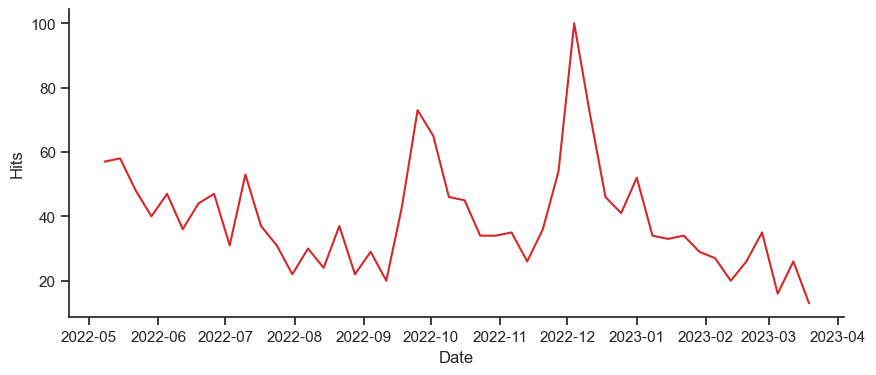

In [9]:
plot('5SOS')

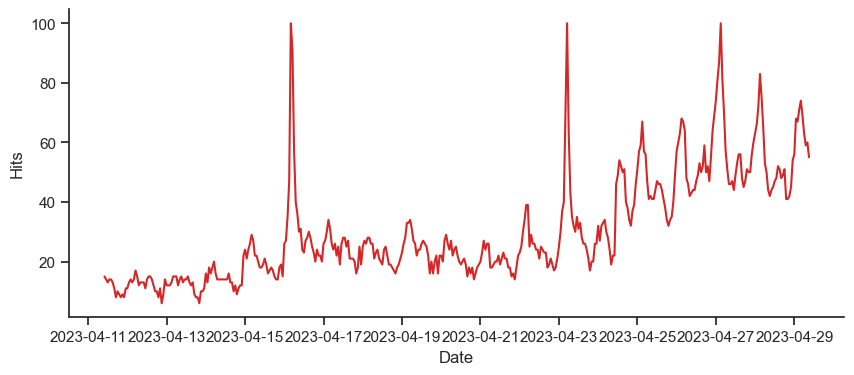

In [10]:
plot('Blackpink')

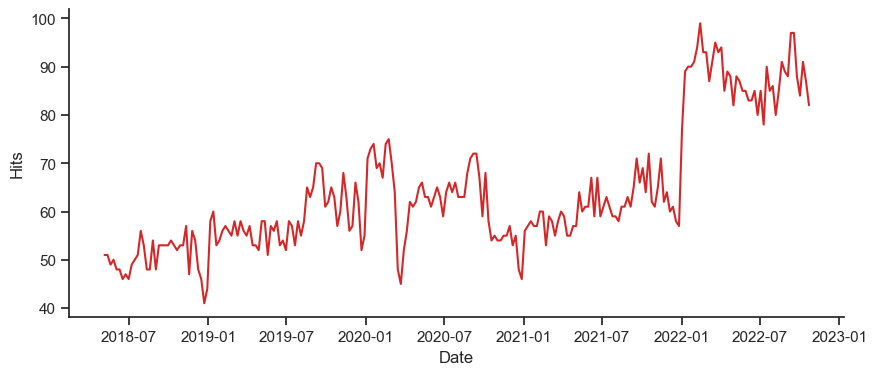

In [11]:
plot('Business Analytics')

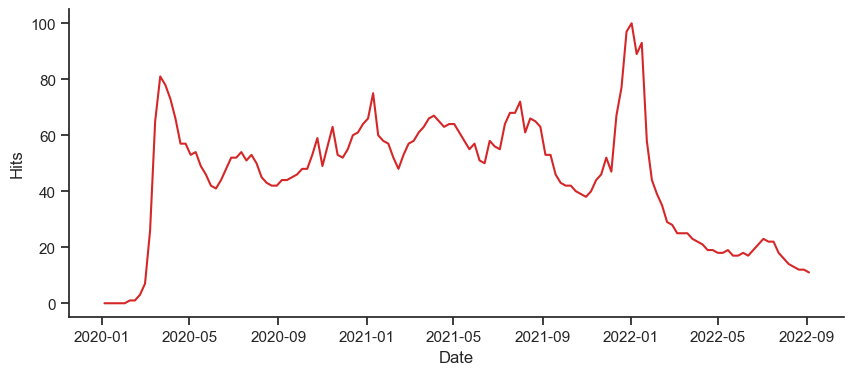

In [12]:
plot('COVID')

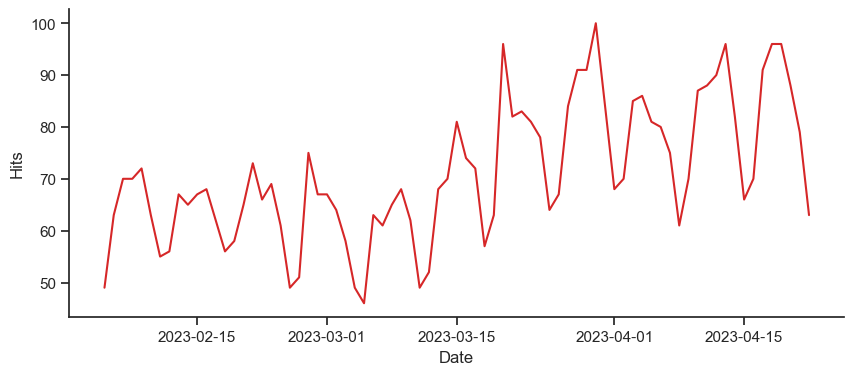

In [13]:
plot('ChatGPT')

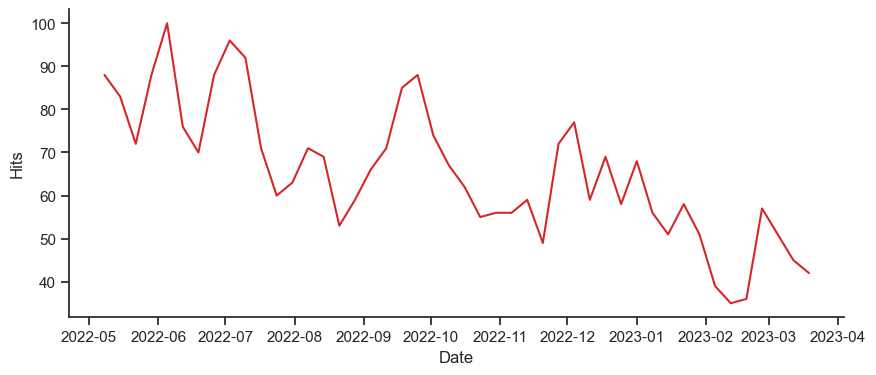

In [14]:
plot('Lazarbeam')

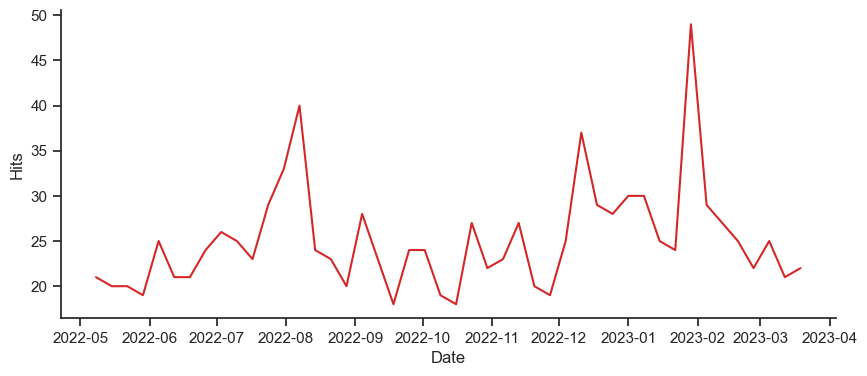

In [15]:
plot('MrBeast')

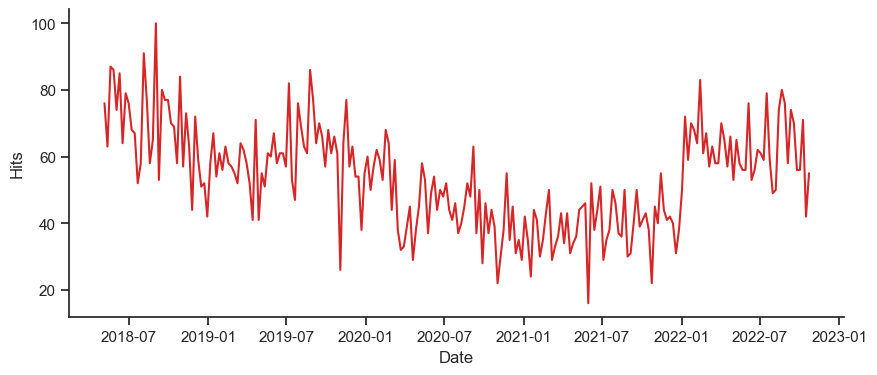

In [16]:
plot('University of New South Wales')

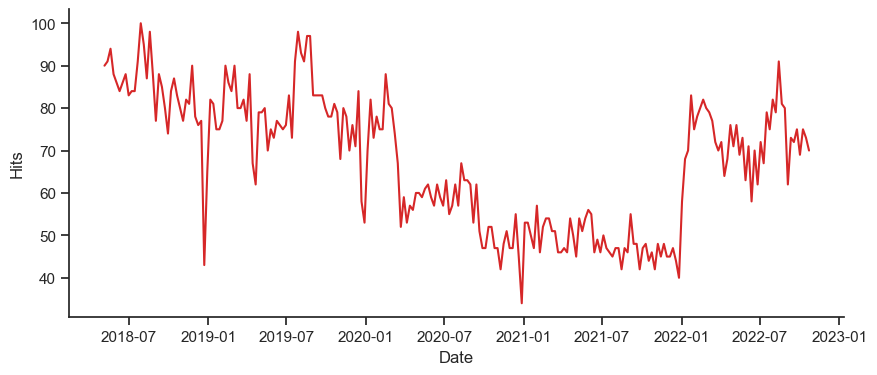

In [17]:
plot('University of Sydney')

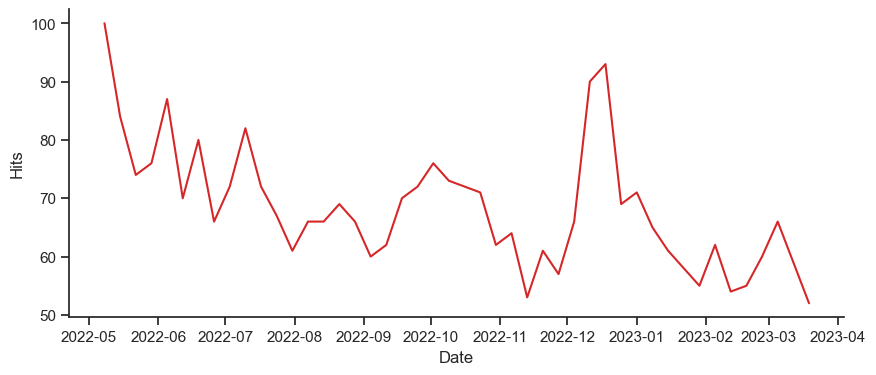

In [18]:
plot('fresh')

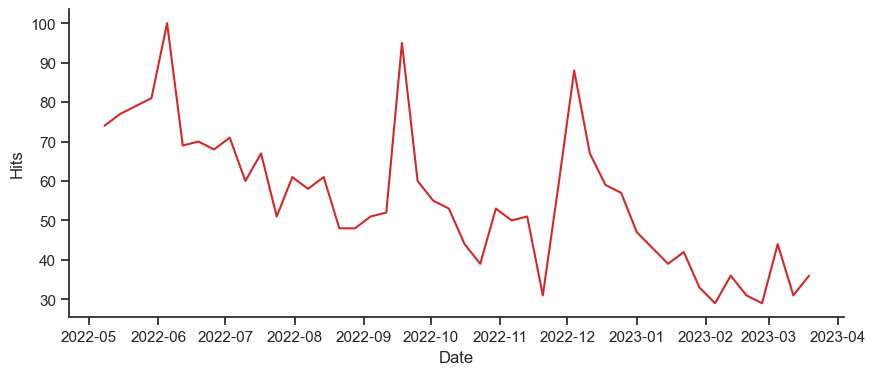

In [19]:
plot('lachlan')

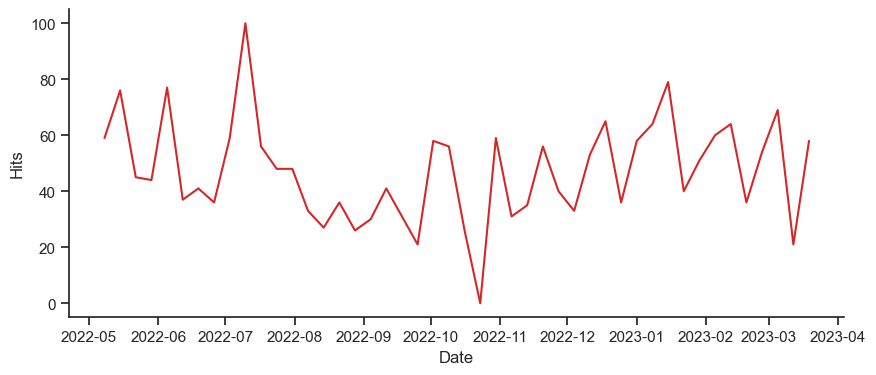

In [20]:
plot('loserfruit')

### Time series Decomposition

The basic function, which applies a moving average to calculate the 'trend' and selects automatically the smoothing window for seasonal pattern was used to initially take a graps of potential trend and seasonal cycle that we can have in each time series. However, because certain keywords have too little observations to use a package to decompose seasonality and trend, thus the function `decomposition_2` was used to manually decompose trend and seasonality for these time series with weekly frequency. Notably, the function is only applied for weekly time series since these keywords that have too little observations all were measured at weekly frequency. The function `decomposition_2` was also used to manually iterate different seasonal cycle to find the suitable period for seasonality in each time series. 

Moreover, followed the textbook https://otexts.com/fpp2/seasonal-strength.html#, it suggests that a time series decomposition can be used to measure the strength of trend and seasonality in a time series (Wang, Smith, & Hyndman, 2006). Hence, I also used the formula suggested by the textbook to measure the strength of trend and seasonality. The strength of trend is measured as 
$$
F_{T} = \text{max} \left( 0, 1 - \frac{\text{Var}(R_{t})}{\text{Var}(T_{t} + R_{t})}\right)
$$

The strength of seasonality is measured as 
$$
F_{S} = \text{max} \left( 0, 1 - \frac{\text{Var}(R_{t})}{\text{Var}(S_{t} + R_{t})}\right)
$$
with the decomposition is written as 
$y_{t} = T_{t} + S_{t} + R_{t}$

For strongly trended data, $F_{T}$ will close to 1, while for data with little or no trend, the $F_{T}$ should be approximately to 0. At the same time, a series with seasonal strength $F_{S}$ close to 0 exhibits almost no seasonality, while a series with strong seasonality will have $F_{S}$ close to 1. The calculation of trend and seasonal strength are only used to get a good sense of what cycle of the potential seasonality that can produce more variation in the time series than the remainder component.

In [21]:
from pylab import rcParams
import statsmodels.tsa.seasonal
def decomposition (keyword):
    n = data.loc[data['keyword'] == keyword, 'hits'].count() 
    y = data.loc[data['keyword'] == keyword, 'hits'].head(-int(np.ceil(n*0.1))) #training set 
    
    decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y) #removing the filter will try to automatically guess the seasonal window
    seasonal = decomposition.seasonal
    trend = decomposition.trend
    resid = decomposition.resid
    
    trend_strength = max(0,(1 - np.var(resid)/np.var(np.add(trend, resid))))
    seasonal_strength = max(0,(1 - np.var(resid)/np.var(np.add(seasonal, resid))))
                        
    rcParams['figure.figsize'] = 14, 8
    decomposition.plot()
    plt.show()
    print('The strength of trend: {}'.format(round(trend_strength,3)))
    print('The strength of seasonality: {}'.format(round(seasonal_strength,3)))

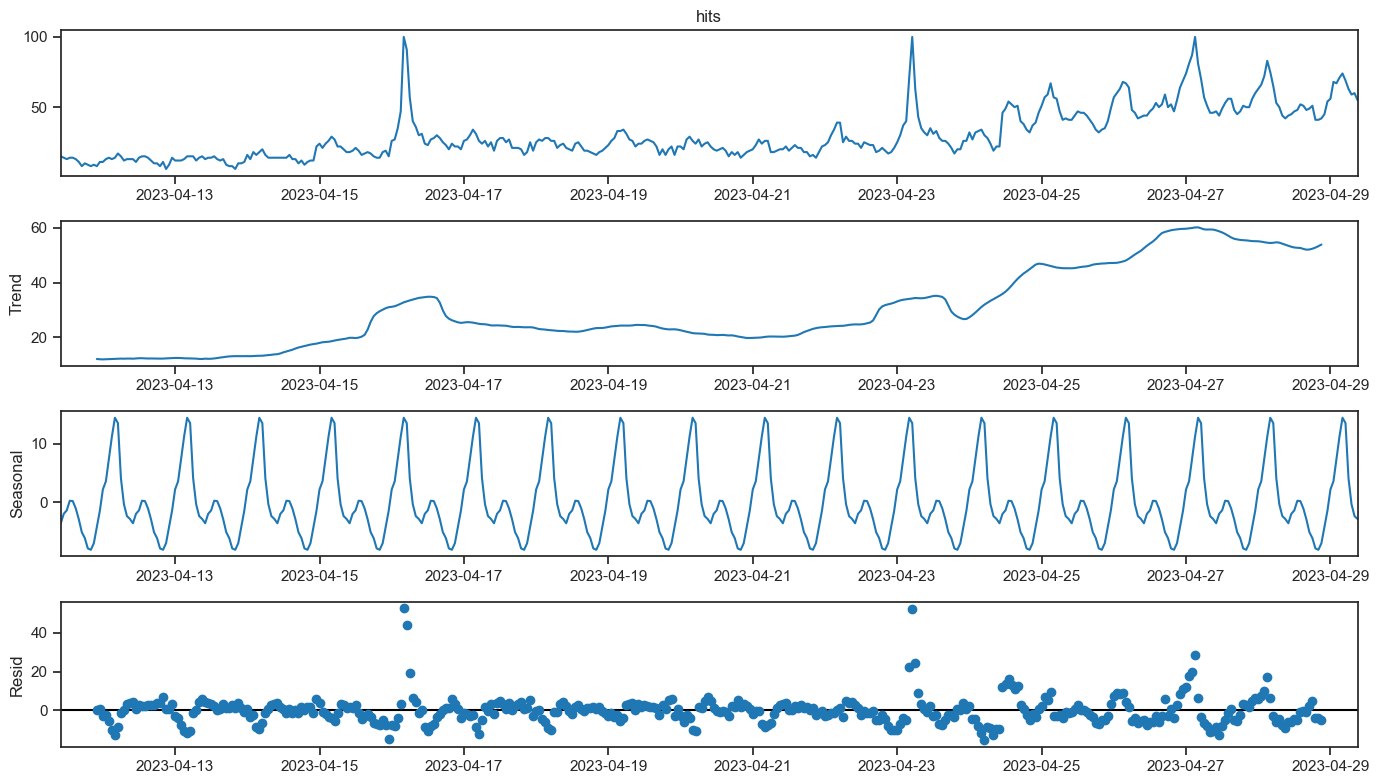

The strength of trend: 0.804
The strength of seasonality: 0.422


In [22]:
decomposition('Blackpink')

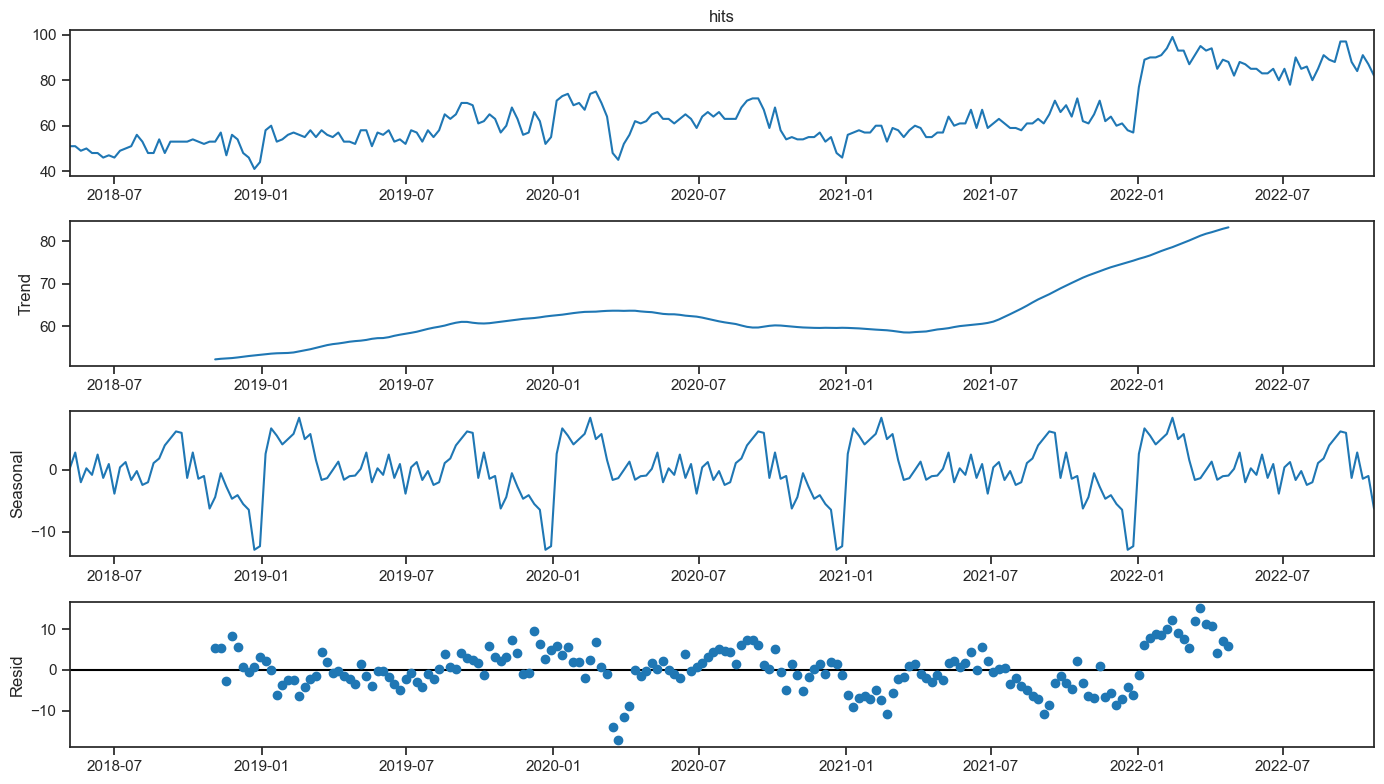

The strength of trend: 0.728
The strength of seasonality: 0.434


In [23]:
decomposition('Business Analytics')

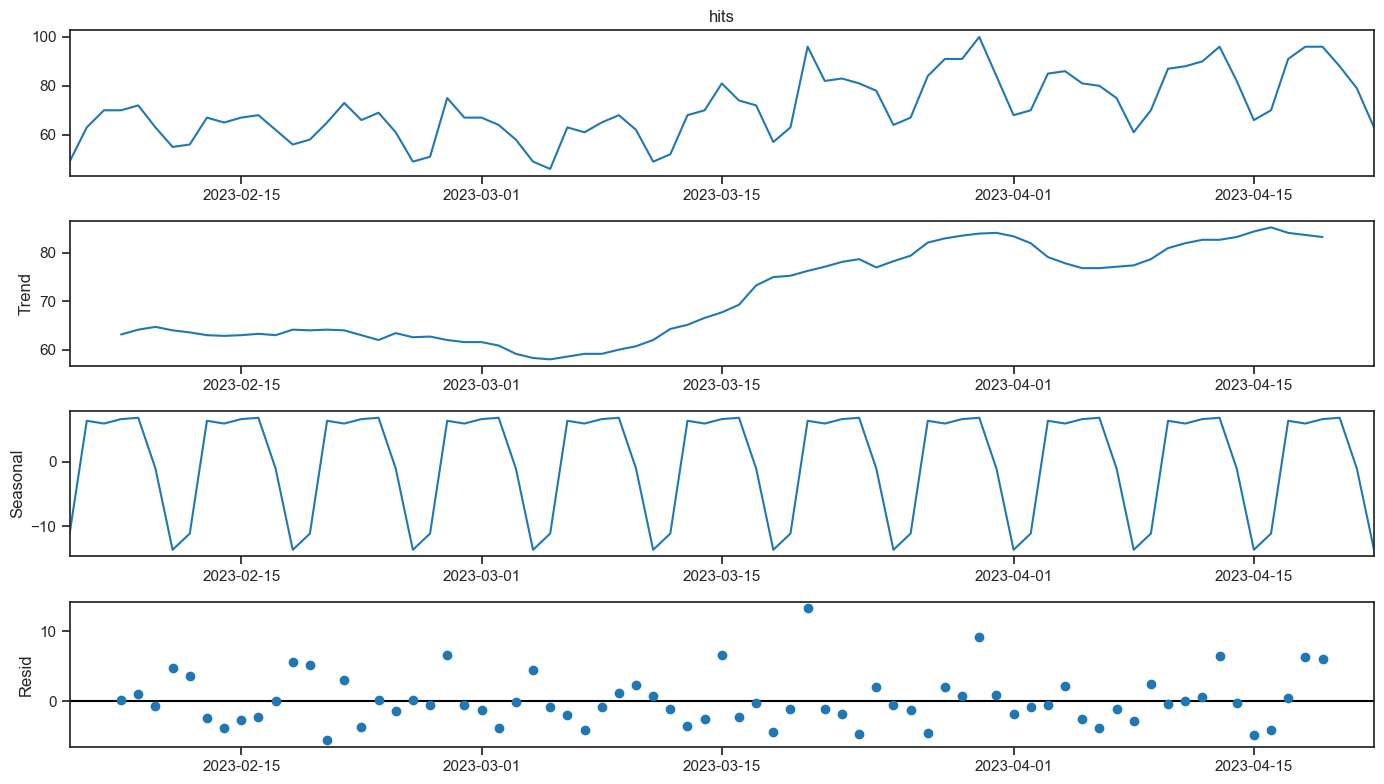

The strength of trend: 0.877
The strength of seasonality: 0.844


In [24]:
decomposition('ChatGPT')

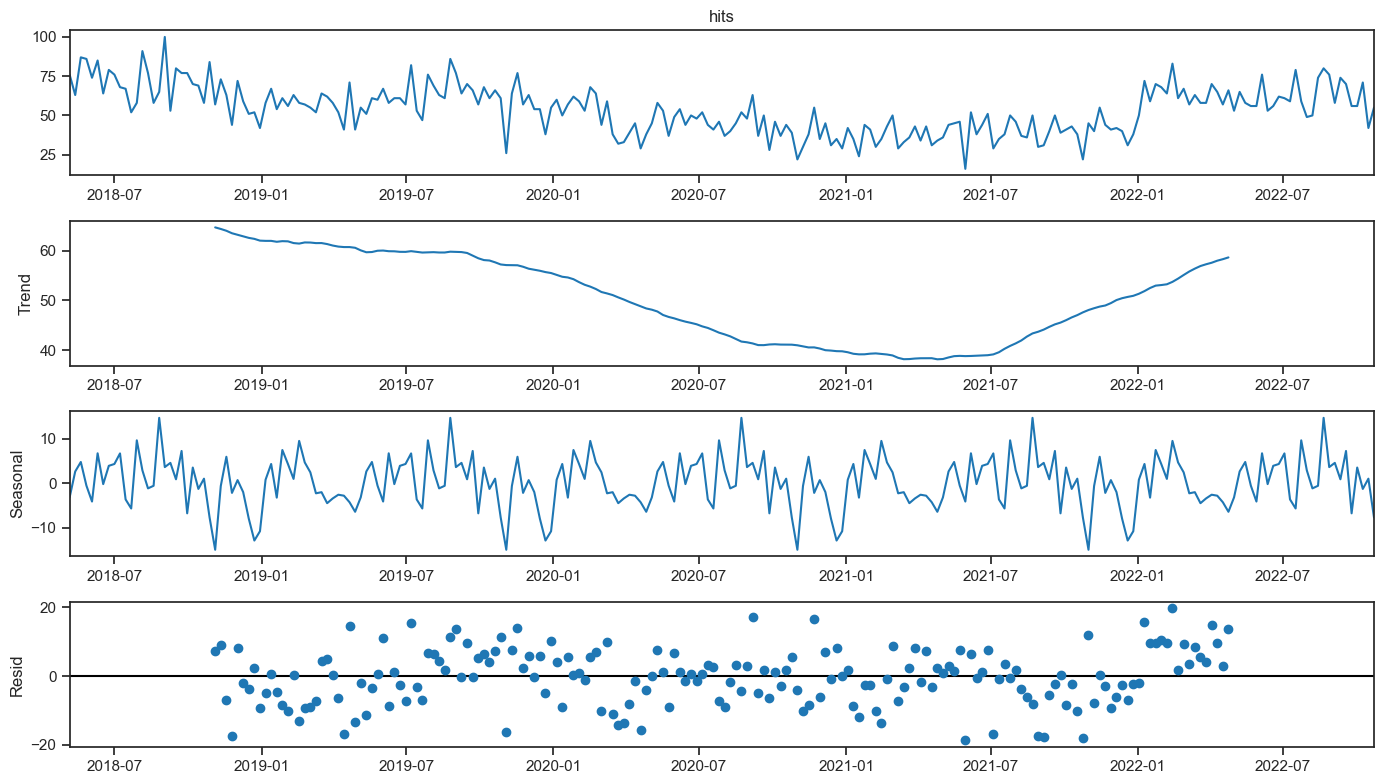

The strength of trend: 0.574
The strength of seasonality: 0.336


In [25]:
decomposition('University of New South Wales')

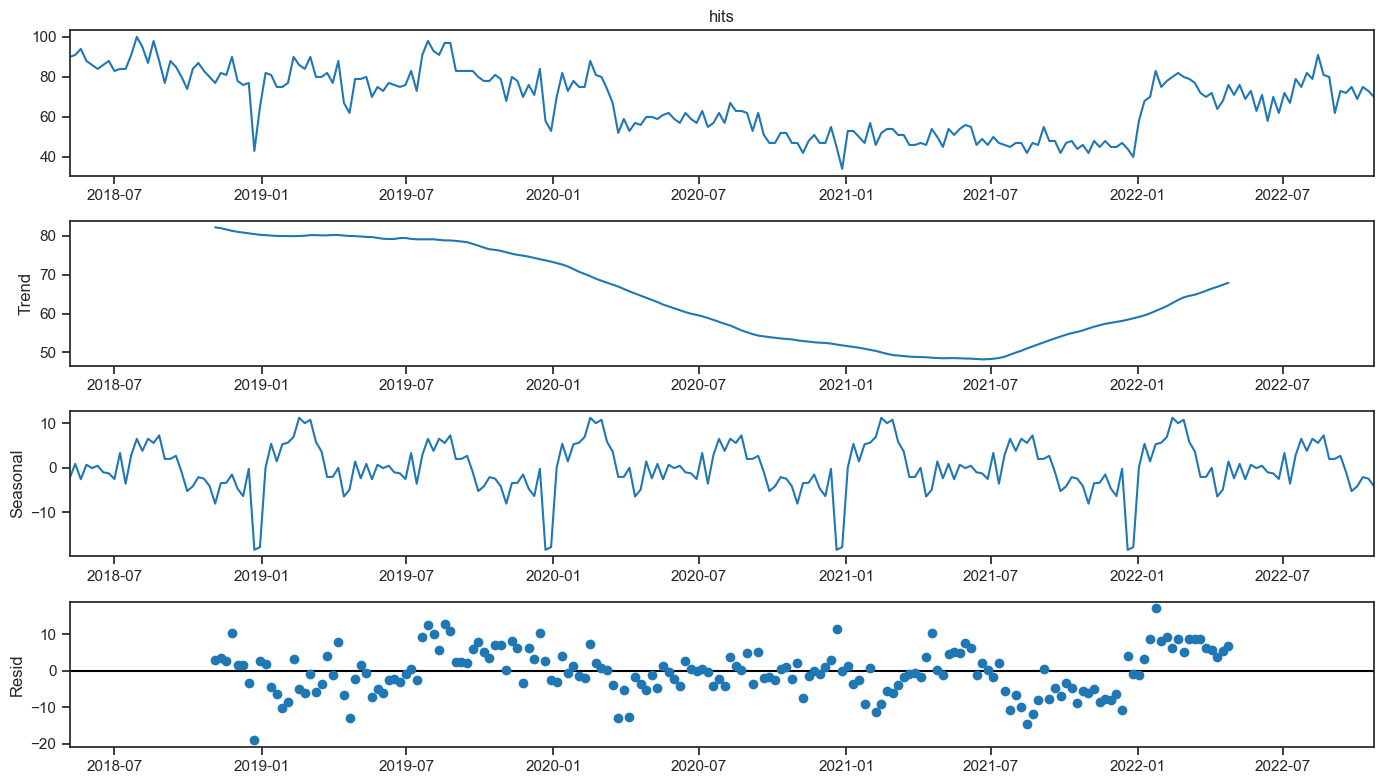

The strength of trend: 0.818
The strength of seasonality: 0.501


In [26]:
decomposition('University of Sydney')

In [27]:
#manually decompose time series
def decomposition_2 (keyword, window) :
    n = data.loc[data['keyword'] == keyword, 'hits'].count() 
    y = data.loc[data['keyword'] == keyword, 'hits'].head(-int(np.ceil(n*0.1))) #training set 
    
    # create the DF
    seasonal_df = y.to_frame()

    # calculate the trend component
    seasonal_df["trend"] = seasonal_df["hits"].rolling(window=window, center=True).mean()

    # detrend the series
    seasonal_df["detrended"] = seasonal_df["hits"] - seasonal_df["trend"]

    # calculate the seasonal component
    seasonal_df.index = pd.to_datetime(seasonal_df.index)
    seasonal_df["week"] = (seasonal_df.index.day-1)//7+1
    seasonal_df["seasonality"] = seasonal_df.groupby("week")["detrended"].transform("mean")

    # get the residuals
    seasonal_df["resid"] = seasonal_df["detrended"] - seasonal_df["seasonality"]
    
    trend_strength = max(0,(1 - np.var(seasonal_df["resid"])/np.var(np.add(seasonal_df["trend"], seasonal_df["resid"]))))
    seasonal_strength = max(0,(1 - np.var(seasonal_df["resid"])/np.var(np.add(seasonal_df["seasonality"], seasonal_df["resid"]))))
                        
    #plot
    (seasonal_df
    .loc[:, ["hits", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive"));
    
    print('The strength of trend: {}'.format(round(trend_strength,3)))
    print('The strength of seasonality: {}'.format(round(seasonal_strength,3)))

The strength of trend: 0.1
The strength of seasonality: 0.154


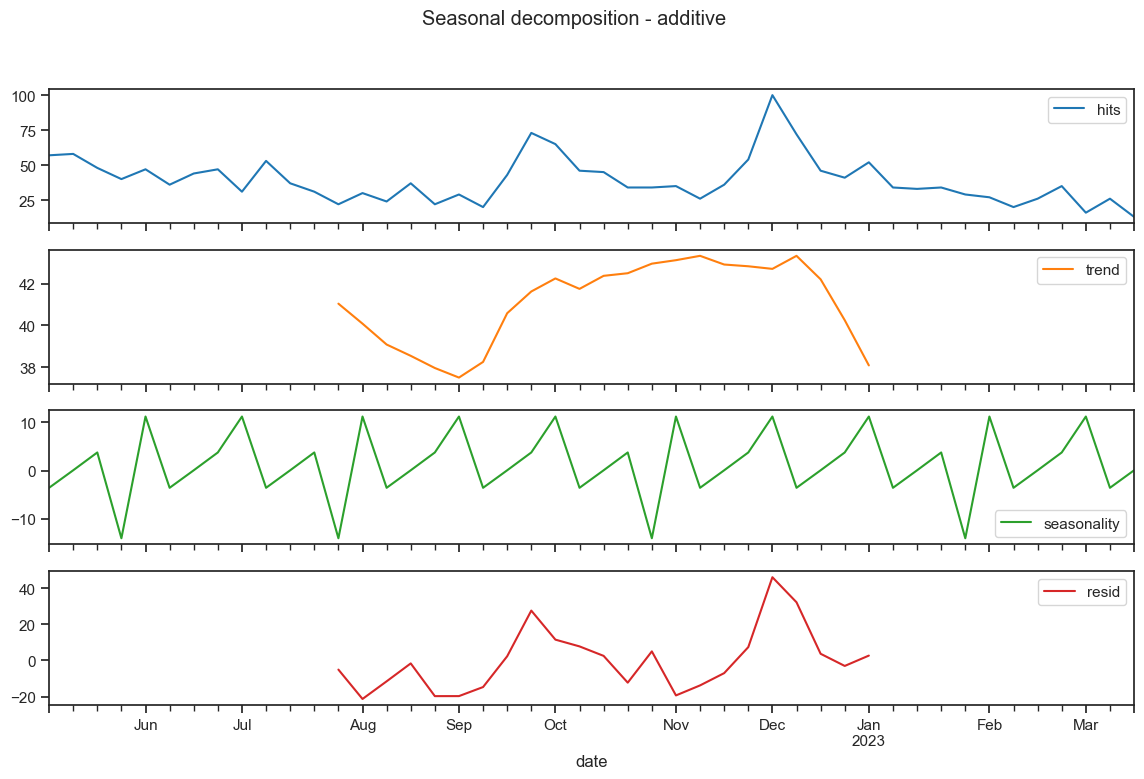

In [28]:
decomposition_2('5SOS', 24)

The strength of trend: 0.884
The strength of seasonality: 0.033


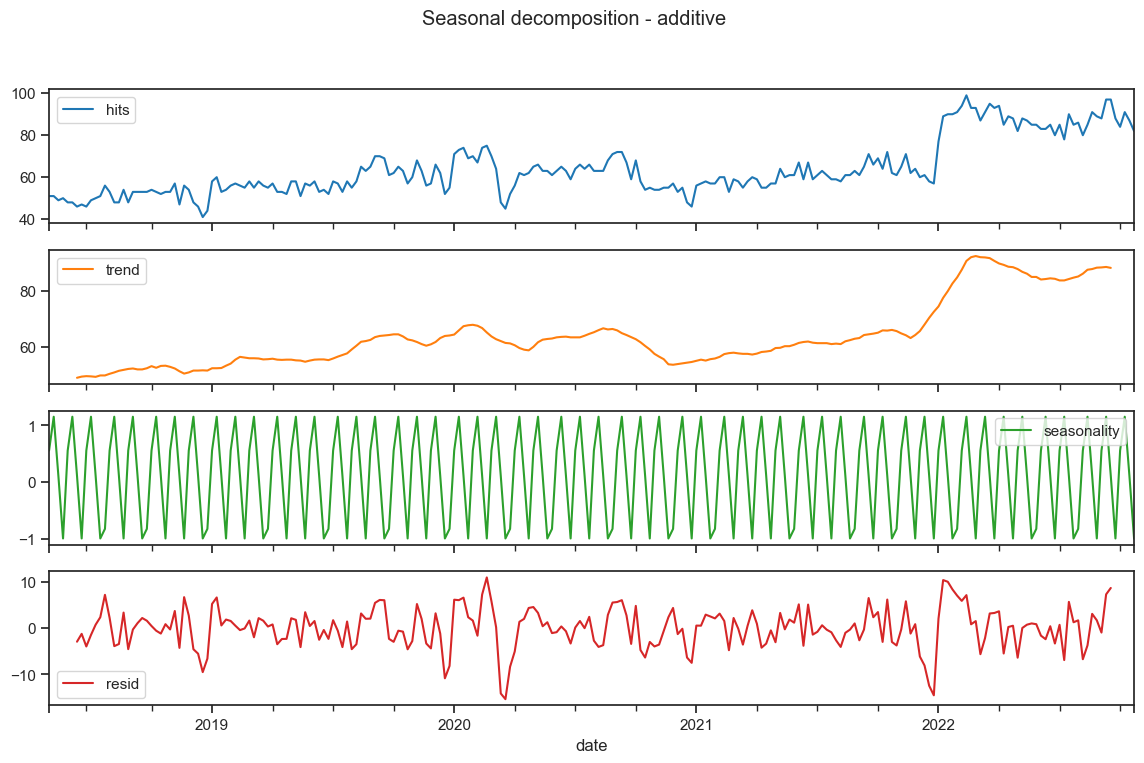

In [29]:
decomposition_2('Business Analytics', 12)

The strength of trend: 0.739
The strength of seasonality: 0.222


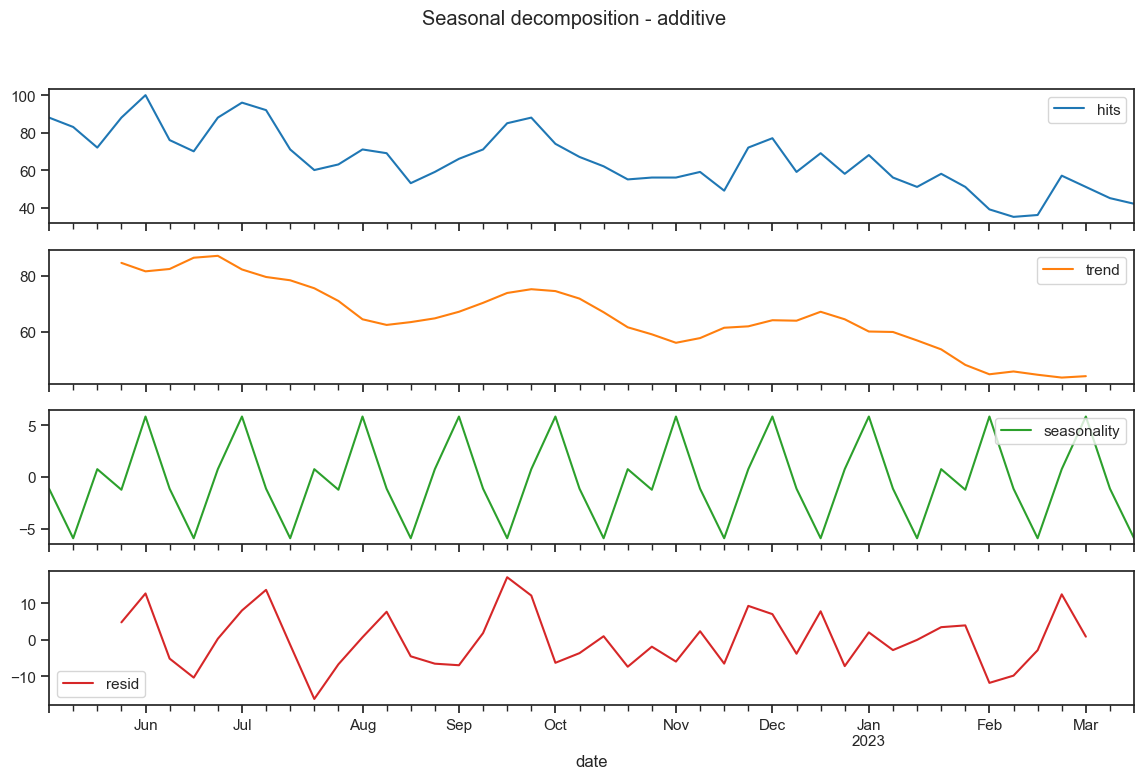

In [30]:
decomposition_2('Lazarbeam', 6)

The strength of trend: 0.939
The strength of seasonality: 0.033


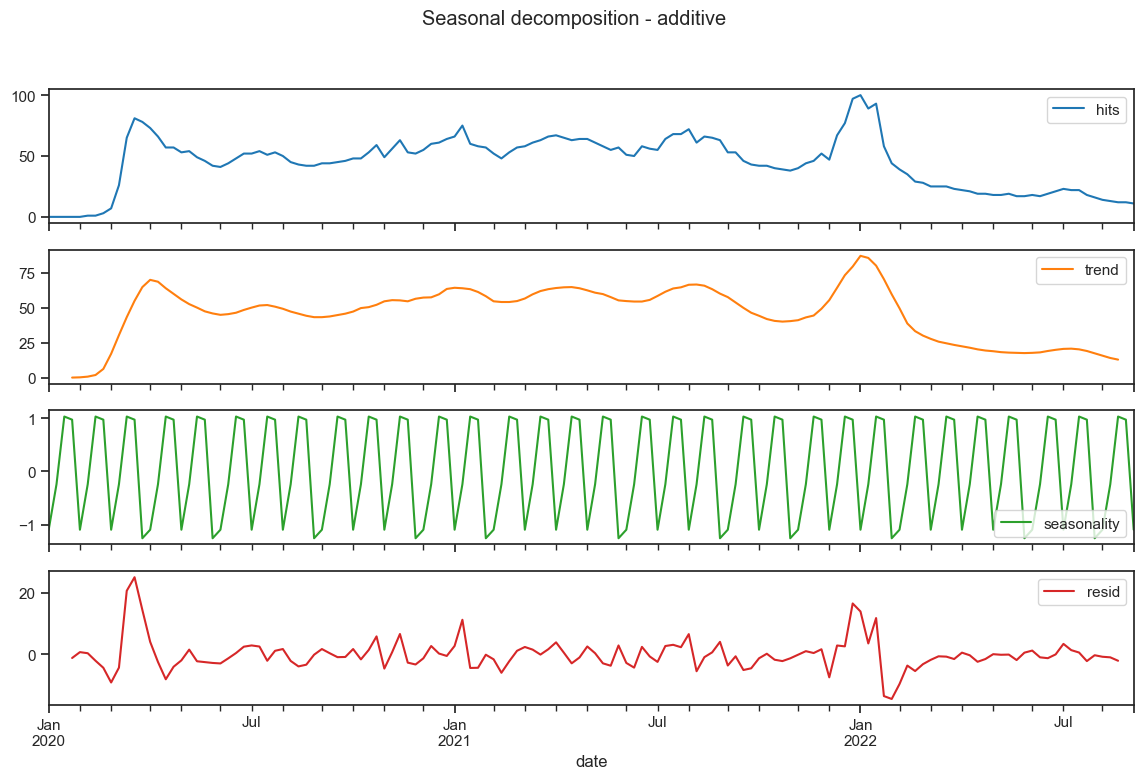

In [31]:
decomposition_2('COVID', 6)

The strength of trend: 0.277
The strength of seasonality: 0.347


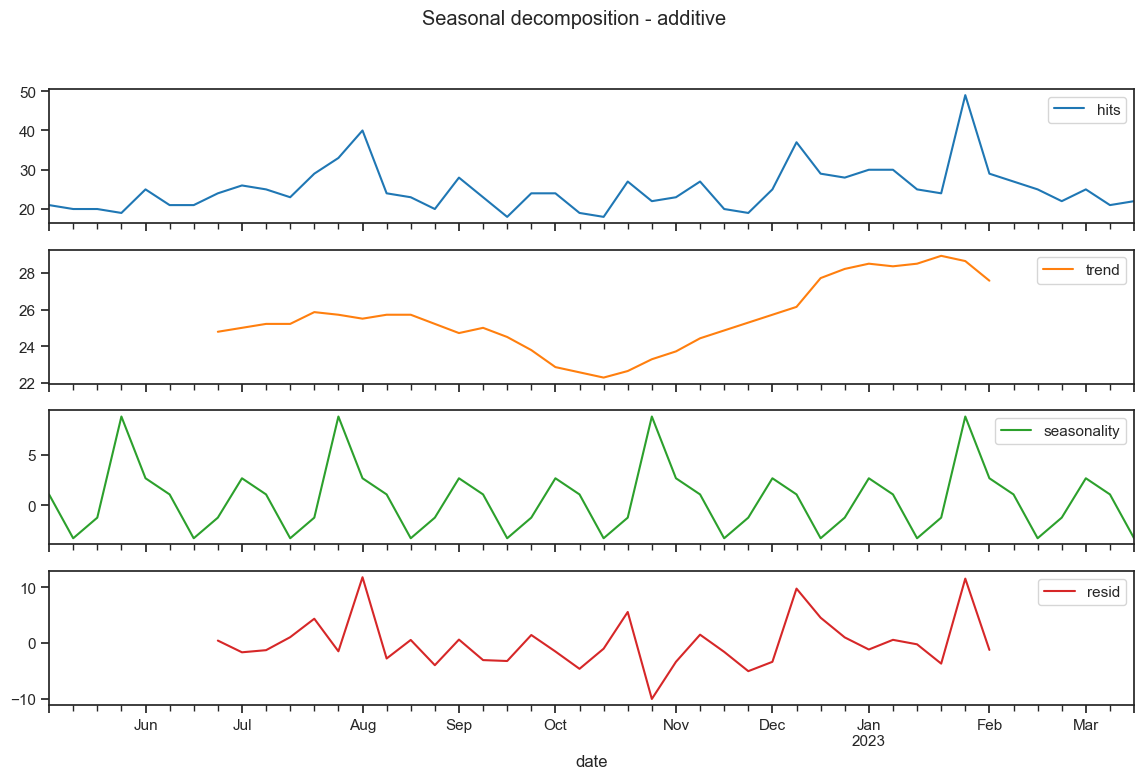

In [32]:
decomposition_2('MrBeast', 14)

The strength of trend: 0.694
The strength of seasonality: 0.023


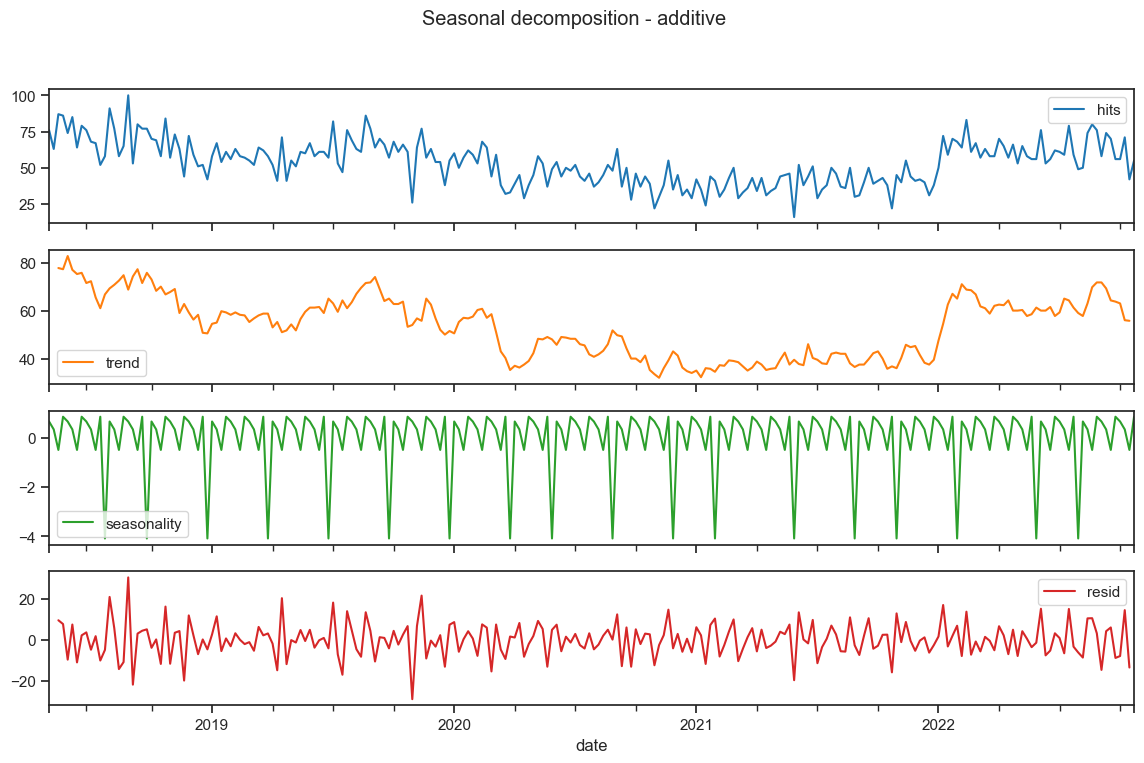

In [33]:
decomposition_2('University of New South Wales', 4)

The strength of trend: 0.892
The strength of seasonality: 0.021


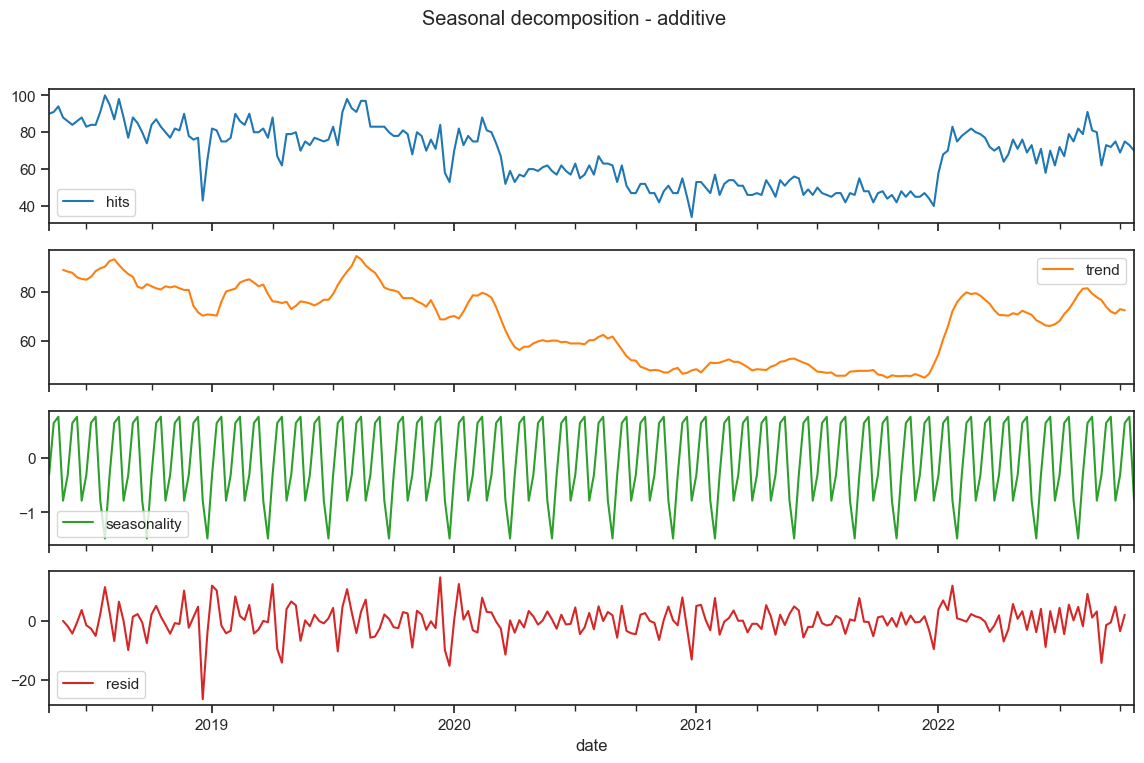

In [34]:
decomposition_2('University of Sydney', 6)

The strength of trend: 0.819
The strength of seasonality: 0.107


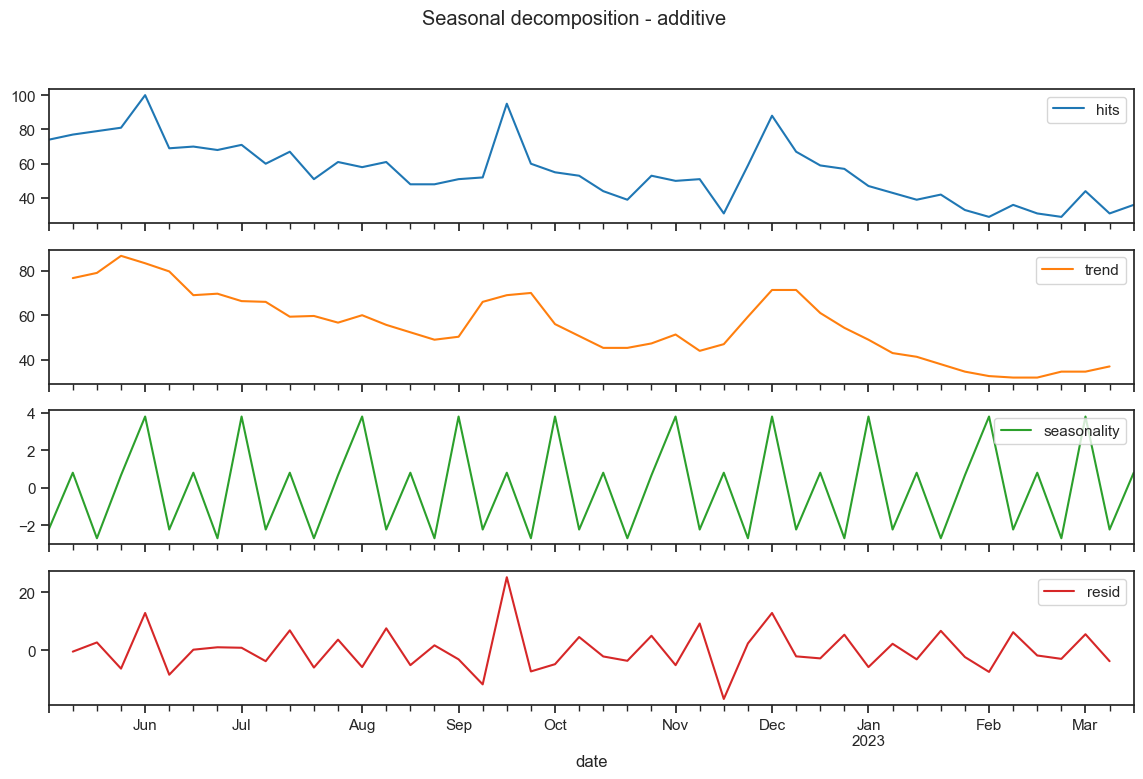

In [35]:
decomposition_2('lachlan', 3)

The strength of trend: 0.603
The strength of seasonality: 0.182


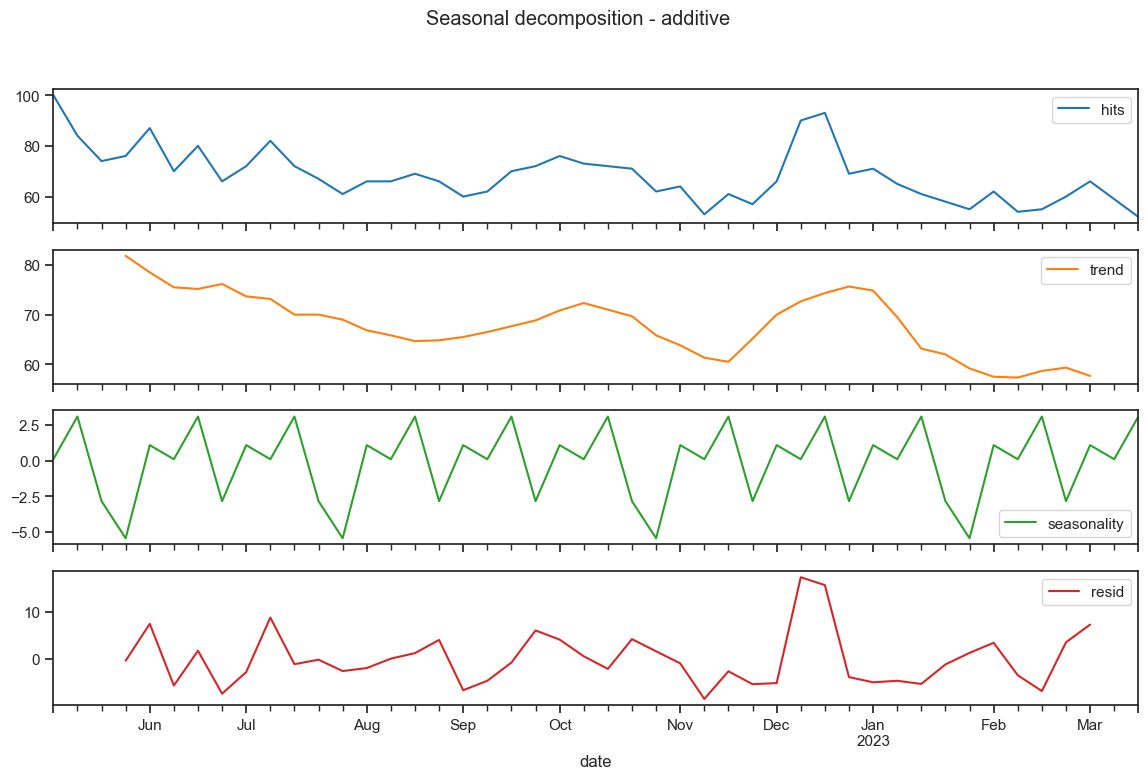

In [36]:
decomposition_2('fresh', 6)

The strength of trend: 0.61
The strength of seasonality: 0.174


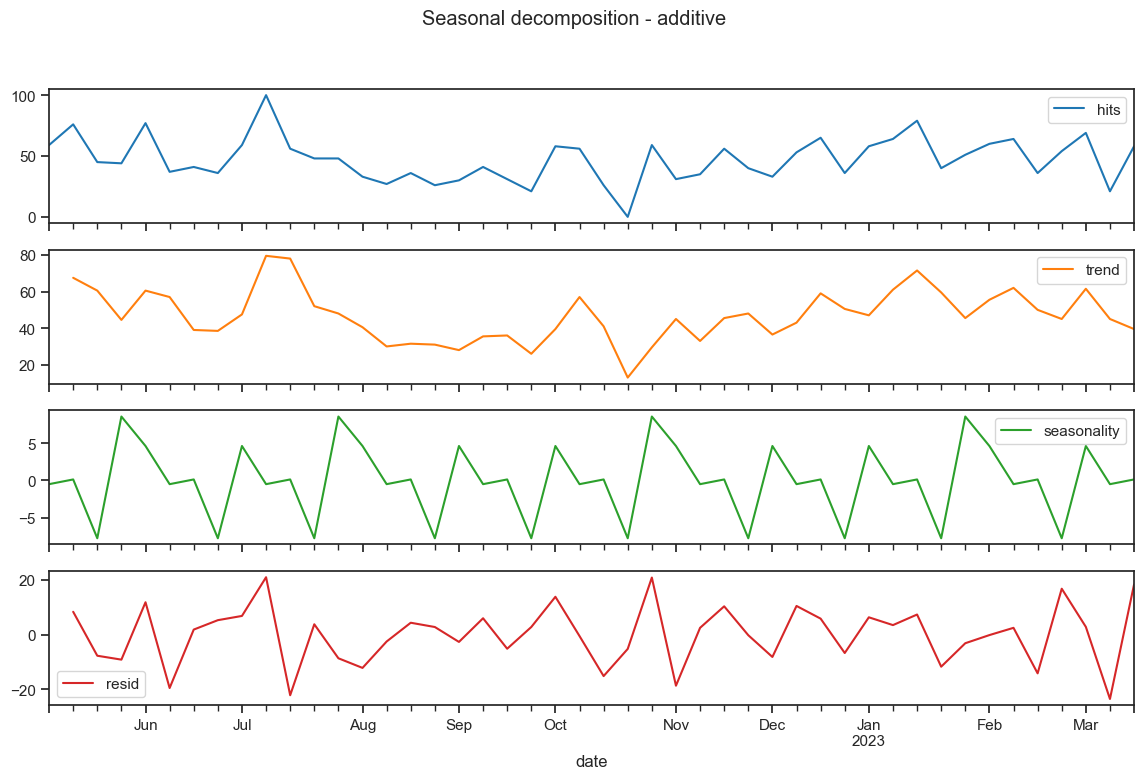

In [37]:
decomposition_2('loserfruit', 2)

### Time series with 0s value

The two time series with 0 values was identified since these time series will need to be added a positive offset when using the log transformation in the model.

In [38]:
y = data.loc[data['keyword'] == 'COVID', 'hits']
y.head(10)

date
2020-01-05 00:00:00+00:00     0
2020-01-12 00:00:00+00:00     0
2020-01-19 00:00:00+00:00     0
2020-01-26 00:00:00+00:00     0
2020-02-02 00:00:00+00:00     0
2020-02-09 00:00:00+00:00     1
2020-02-16 00:00:00+00:00     1
2020-02-23 00:00:00+00:00     3
2020-03-01 00:00:00+00:00     7
2020-03-08 00:00:00+00:00    26
Name: hits, dtype: int64

In [39]:
y = data.loc[data['keyword'] == 'loserfruit', 'hits']
y['2022-10':'2022-11'] #has 0 value 

date
2022-10-02 00:00:00+00:00    58
2022-10-09 00:00:00+00:00    56
2022-10-16 00:00:00+00:00    26
2022-10-23 00:00:00+00:00     0
2022-10-30 00:00:00+00:00    59
2022-11-06 00:00:00+00:00    31
2022-11-13 00:00:00+00:00    35
2022-11-20 00:00:00+00:00    56
2022-11-27 00:00:00+00:00    40
Name: hits, dtype: int64

## Model selection 

The function is written based on time series cross validation to select model that produce the least forecast error i.e., MAE for each time series. This method compares several models including random walk, seasonal random walk, simple exponential smoothing, Holt's linear trend method, Holt-Winters' additive and multiplicative method, Holt-Winters’ damped method, ARIMA as well as Holt-Winters' additive and ARIMA with log transformation of time series. Notably, the ARIMA model in this function is chosen by `pmdarima` package which is an automatic process of 'trying many possible models' and selecting the best one by some validation criterion (AIC, crossval). Thus it reduces the cumbersomeness and time-consuming of fitting ARIMA manually. 

The function takes two parameters such as 'keyword' which specifies the time series for a given keyword and 'seasonality' which specifies the seasonal cycle of each time series. The input for seasonal parameter is the seasonal cycle that was identified from above time-series decomposition section. It is worth noting that the function will always have a specfic number as an input for seasonality in model selection process of every time series even though there might be some non-seasonal time series since some seasonal components were found in time series decomposition analysis are weak. Nevertheless, a time series with strong seasonality will be captured by the seasonal naive or Holt-Winter model in the function that consider seasonal pattern. However if data appear to have little or no seasonality (the seasonal component that was identified in above section is negligible), the function may decide that the simpler model or non-seasonal ARIMA will be enough as they have better performance. This is the same when considering trend in a time series. 

In [40]:
#cross validation 
import forecast
def forecasting(keyword, seasonality) :
    y = data.loc[data['keyword'] == keyword, 'hits']
    log_y = np.log(data.loc[data['keyword'] == keyword, 'hits'])
    start = observations.loc[keyword,'Train Obs'] #start of test data 
    test = data.loc[data['keyword'] == keyword, 'hits'].tail(observations.loc[keyword,'Test Obs']).index
    actual= []
    pred1 = []
    pred2 = []
    pred3 = []
    pred4 = []
    pred5 = []
    pred6 = []
    pred7 = []
    pred8 = []
    pred9 = []
    pred10 = []
    pred11 = []
    
    for i in range(start, len(y)): #cross-validation of time series 
        actual.append(y.iloc[i]) # actual value
        pred1.append(y.iloc[i - 1]) # random walk forecast
        
        pred2.append(y.iloc[i - seasonality]) #seasonal walk forecast
        
        ses = forecast.ses(y.iloc[:i]) 
        ses.fit()
        pred3.append(ses.forecast(1)[0]) # SES forecast
        
        holt = forecast.holt(y.iloc[:i]) 
        holt.fit()
        pred4.append(holt.forecast(1)[0]) #Holt forecast
        
        ahw = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=seasonality)
        ahw.fit()
        pred5.append(ahw.forecast(1)[0]) # additive holt winters forecast
        
        mhw = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=seasonality)
        mhw.fit()
        pred6.append(mhw.forecast(1)[0]) # multiplicate holt winters forecast
        
        d_ahw = forecast.holtwinters(y.iloc[:i], additive=True, damped=True, m=seasonality)
        d_ahw.fit()
        pred7.append(d_ahw.forecast(1)[0]) # damped additive holt winters forecast
        
        log_ahw = forecast.holtwinters(log_y.iloc[:i], additive=True, damped=False, m=seasonality)
        log_ahw.fit() #log-scale forecast
        pred8.append(np.exp(log_ahw.forecast(1)[0]))
        
        arima = pm.auto_arima(y.iloc[:i], seasonal=True, m=1) #Auto-ARIMA 
        pred9.append(arima.predict(1)[0])
        
        log_arima = pm.auto_arima(log_y.iloc[:i], seasonal=True, m=1) #Auto-ARIMA with log 
        pred10.append(np.exp(log_arima.predict(1)[0]))
       
    columns=['RW', 'Seasonal RW','SES','Holt Model','Additive HoltWinter', 'Multiplicative HoltWinter',
             'Damped Additive','Log Additive', 'Auto ARIMA','Log Auto ARIMA','Actual'] 
    results = np.vstack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10, actual]).T
    results = pd.DataFrame(results, columns=columns, index=test)
    return results.round(3)

In [41]:
def best_model(keyword, seasonality):
    results = forecasting(keyword, seasonality)
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAE'])
    for i in range(10):
        table.iloc[i,0] = np.mean(np.abs(results.iloc[:,i] - results.iloc[:,-1]))
     
    best_model = min(table.idxmin())
    print('The best model to forecast number of searches for ' + str(keyword) + ' is ' + str(best_model))
    
    return table.round(3)

In [42]:
best_model('5SOS', 24)

The best model to forecast number of searches for 5SOS is Log Auto ARIMA


MAE
RW                          5.500
Seasonal RW                10.167
SES                         7.247
Holt Model                  7.247
Additive HoltWinter        11.490
Multiplicative HoltWinter   5.386
Damped Additive             7.967
Log Additive                6.174
Auto ARIMA                  4.128
Log Auto ARIMA              3.756

In [43]:
#takes long time to run 
best_model('Blackpink', 24) #seasonality pattern 24 hours for each cycle 

The best model to forecast number of searches for Blackpink is RW


MAE
RW                         3.204
Seasonal RW                4.510
SES                        5.980
Holt Model                 5.980
Additive HoltWinter        5.128
Multiplicative HoltWinter  4.418
Damped Additive            5.910
Log Additive               4.658
Auto ARIMA                 3.217
Log Auto ARIMA             3.239

In [44]:
best_model('Business Analytics', 12)

The best model to forecast number of searches for Business Analytics is Log Auto ARIMA


MAE
RW                         5.074
Seasonal RW                8.741
SES                        6.985
Holt Model                 6.985
Additive HoltWinter        6.833
Multiplicative HoltWinter  6.911
Damped Additive            5.877
Log Additive               6.946
Auto ARIMA                 4.651
Log Auto ARIMA             4.601

In [45]:
best_model('ChatGPT', 7)

The best model to forecast number of searches for ChatGPT is Seasonal RW


MAE
RW                          9.000
Seasonal RW                 4.111
SES                        16.444
Holt Model                 16.187
Additive HoltWinter         5.865
Multiplicative HoltWinter   5.538
Damped Additive             5.865
Log Additive                5.456
Auto ARIMA                  5.866
Log Auto ARIMA              7.895

In [46]:
best_model('Lazarbeam', 6) 

The best model to forecast number of searches for Lazarbeam is Multiplicative HoltWinter


MAE
RW                         8.000
Seasonal RW                7.667
SES                        7.178
Holt Model                 7.178
Additive HoltWinter        5.751
Multiplicative HoltWinter  5.641
Damped Additive            5.751
Log Additive               5.989
Auto ARIMA                 8.000
Log Auto ARIMA             8.202

In [47]:
best_model('MrBeast', 14)

The best model to forecast number of searches for MrBeast is Log Auto ARIMA


MAE
RW                         24.333
Seasonal RW                19.000
SES                        22.426
Holt Model                 20.416
Additive HoltWinter        21.340
Multiplicative HoltWinter  21.374
Damped Additive            21.332
Log Additive               23.272
Auto ARIMA                 17.860
Log Auto ARIMA             14.913

In [48]:
best_model('University of New South Wales', 4)

The best model to forecast number of searches for University of New South Wales is Auto ARIMA


MAE
RW                         11.741
Seasonal RW                11.667
SES                         9.541
Holt Model                  9.541
Additive HoltWinter        10.260
Multiplicative HoltWinter  10.481
Damped Additive            10.259
Log Additive               10.482
Auto ARIMA                  9.396
Log Auto ARIMA              9.712

In [49]:
best_model('University of Sydney', 6)

The best model to forecast number of searches for University of Sydney is Log Auto ARIMA


MAE
RW                         8.741
Seasonal RW                9.630
SES                        7.884
Holt Model                 7.884
Additive HoltWinter        7.986
Multiplicative HoltWinter  8.028
Damped Additive            7.985
Log Additive               8.035
Auto ARIMA                 7.499
Log Auto ARIMA             7.406

In [50]:
best_model('fresh', 3)

The best model to forecast number of searches for fresh is Seasonal RW


MAE
RW                         6.500
Seasonal RW                3.333
SES                        5.343
Holt Model                 5.343
Additive HoltWinter        4.090
Multiplicative HoltWinter  4.496
Damped Additive            4.091
Log Additive               4.272
Auto ARIMA                 6.500
Log Auto ARIMA             6.500

In [51]:
best_model('lachlan', 2) 

The best model to forecast number of searches for lachlan is Damped Additive


MAE
RW                         5.667
Seasonal RW                5.333
SES                        3.759
Holt Model                 3.765
Additive HoltWinter        3.307
Multiplicative HoltWinter  3.462
Damped Additive            3.303
Log Additive               3.571
Auto ARIMA                 4.248
Log Auto ARIMA             4.545

### Model selection for time series with 0 value

The time series of keyword 'COVD' and 'loserfruit' contains 0 values, these 0 values can be a perfectly valid value in the context that there no searches for 'COVD' and 'loserfruit' in a particular week. Thus, I modified the function by adding a small positive offset of 1 to all time series when doing log transformation so that the models that fit log time series can work properly; and a reversible transformation of log(x+1) is exp(x) - 1. 

In [52]:
#cross validation 
import forecast
def forecasting_2(keyword, seasonality) :
    y = data.loc[data['keyword'] == keyword, 'hits']
    log_y = np.log(data.loc[data['keyword'] == keyword, 'hits'] + 1) #adding a positive offset of 1 to the time series for log transformation
    start = observations.loc[keyword,'Train Obs'] #start of test data 
    test = data.loc[data['keyword'] == keyword, 'hits'].tail(observations.loc[keyword,'Test Obs']).index
    actual= []
    pred1 = []
    pred2 = []
    pred3 = []
    pred4 = []
    pred5 = []
    pred6 = []
    pred7 = []
    pred8 = []
    pred9 = []
    pred10 = []
    pred11 = []
    
    for i in range(start, len(y)): #cross-validation of time series 
        actual.append(y.iloc[i]) # actual value
        pred1.append(y.iloc[i - 1]) # random walk forecast
        
        pred2.append(y.iloc[i - seasonality]) #seasonal walk forecast
        
        ses = forecast.ses(y.iloc[:i]) 
        ses.fit()
        pred3.append(ses.forecast(1)[0]) # SES forecast
        
        holt = forecast.holt(y.iloc[:i]) 
        holt.fit()
        pred4.append(holt.forecast(1)[0]) #Holt forecast
        
        ahw = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=seasonality)
        ahw.fit()
        pred5.append(ahw.forecast(1)[0]) # additive holt winters forecast
        
        d_ahw = forecast.holtwinters(y.iloc[:i], additive=True, damped=True, m=seasonality)
        d_ahw.fit()
        pred6.append(d_ahw.forecast(1)[0]) # damped additive holt winters forecast
        
        log_ahw = forecast.holtwinters(log_y.iloc[:i], additive=True, damped=False, m=seasonality)
        log_ahw.fit() #log-scale forecast
        pred7.append(np.exp(log_ahw.forecast(1)[0]) - 1)
        
        arima = pm.auto_arima(y.iloc[:i], seasonal=True, m=1) #Auto-ARIMA 
        pred8.append(arima.predict(1)[0])
        
        log_arima = pm.auto_arima(log_y.iloc[:i], seasonal=True, m=1) #Auto-ARIMA with log 
        pred9.append(np.exp(log_arima.predict(1)[0]) - 1)
       
    columns=['RW', 'Seasonal RW','SES','Holt Model','Additive HoltWinter',
             'Damped Additive','Log Additive', 'Auto ARIMA','Log Auto ARIMA','Actual'] 
    results = np.vstack([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, actual]).T
    results = pd.DataFrame(results, columns=columns, index=test)
    return results.round(3)

In [53]:
def best_model_2(keyword, seasonality):
    results = forecasting_2(keyword, seasonality)
    table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['MAE'])
    for i in range(9):
        table.iloc[i,0] = np.mean(np.abs(results.iloc[:,i] - results.iloc[:,-1]))
     
    best_model = min(table.idxmin())
    print('The best model to forecast number of searches for ' + str(keyword) + ' is ' + str(best_model))
    
    return table.round(3)

In [54]:
best_model_2('COVID', 6)

The best model to forecast number of searches for COVID is RW


MAE
RW                   0.688
Seasonal RW          1.750
SES                  0.750
Holt Model           0.750
Additive HoltWinter  0.812
Damped Additive      0.824
Log Additive         1.003
Auto ARIMA           0.914
Log Auto ARIMA       0.983

In [55]:
best_model_2('loserfruit', 3)

The best model to forecast number of searches for loserfruit is Additive HoltWinter


MAE
RW                   12.833
Seasonal RW          11.500
SES                   8.653
Holt Model            8.653
Additive HoltWinter   7.662
Damped Additive       8.023
Log Additive         10.156
Auto ARIMA            8.959
Log Auto ARIMA       10.719

## Model diagnostics

The best models were diagnosed to see if they satisfy the properties of good forecasting method which are: 
- The residuals are uncorrelated. 
- The residuals have zero mean.
- The residuals have constant variance.
- The residuals are normally distributed.

If the chosen models do not satisfy these properties, it might signify that these models will need to be improved. This exercise was only undertaken to take the look at the model holding assumptions, thus the additional modifications to the chosen model will be not considered, and the best model were chosen solely based on cross-validation result and its forecast performance. 

The residual diagnostic is conducted for assessing the best model that was chosen for every time series in above section. The key diagnostics for univariate time series are: 

1. Residual plot.
2. Residula ACF.
3. Residual distribution plots.

I compute the plot for diagnostics as follows.

In [56]:
def diagnostic(resid) :
    fig = plt.figure(figsize=(14,12))
    ax1 = fig.add_subplot(3,1,1)
    plt.plot(resid, color=blue)
    ax1.set_ylabel("Residuals")
    ax1.set_xticks([], minor=True)

    ax2 = fig.add_subplot(3,1,2)
    sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax2) 

    ax3 = fig.add_subplot(3,1,3)
    sns.distplot(resid, ax=ax3, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                     kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig

#### Forecast of 5SOS - Auto ARIMA with log transformation of time series

In [57]:
sos_h = int(observations.loc['5SOS','Test Obs']) #forecast horizon
sos_train = data.loc[data['keyword'] == '5SOS', 'hits'].head(-(observations.loc['5SOS','Test Obs']))

#model 
log_train = np.log(sos_train) 
log_arima = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 
sos_resid = (log_train-log_arima.fittedvalues()) # residuals

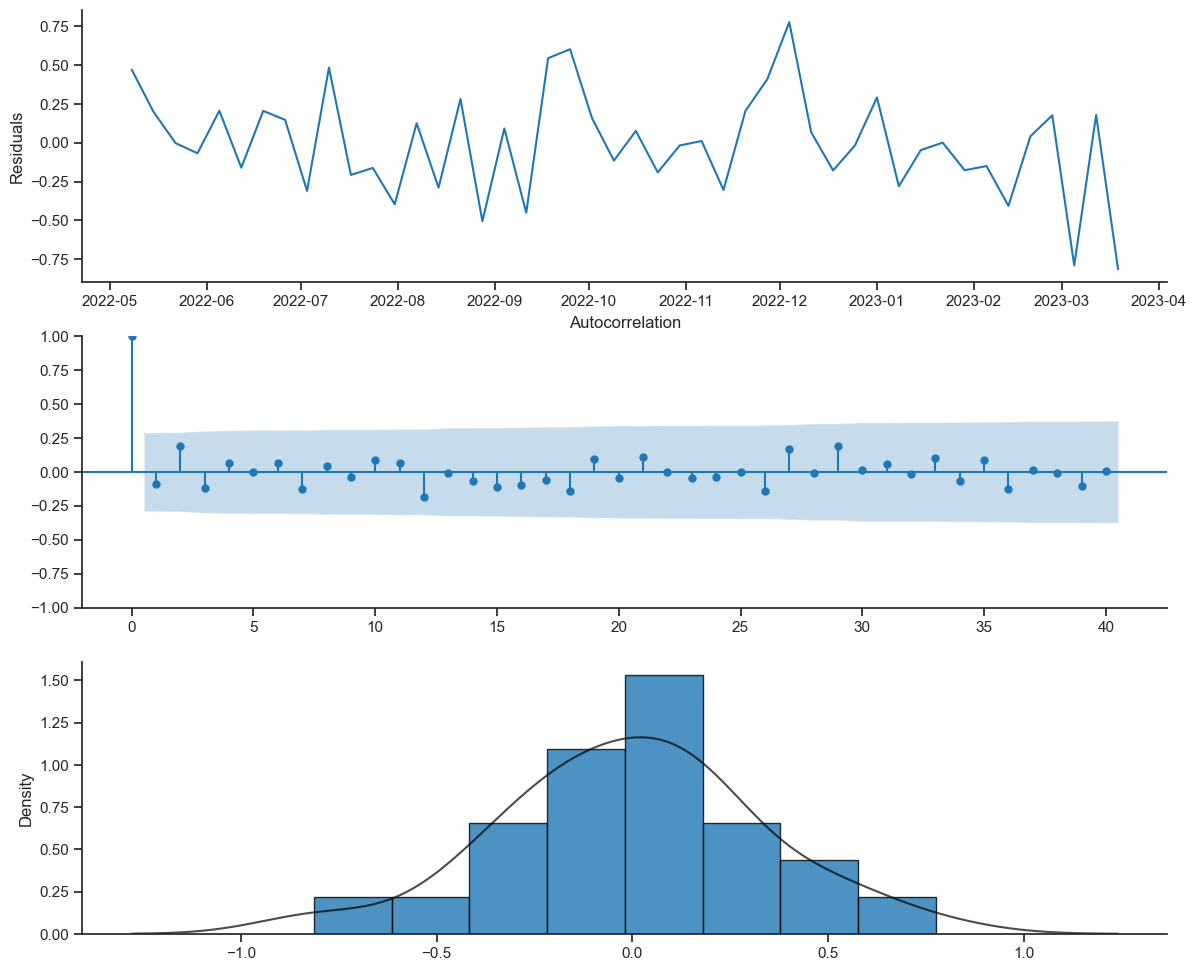

In [58]:
diagnostic(sos_resid)
plt.show()

#### Forecast of Blackpink - Random Walk 

In [59]:
bp_h = int(observations.loc['Blackpink','Test Obs']) #forecast horizon
bp_train = data.loc[data['keyword'] == 'Blackpink', 'hits'].head(-(observations.loc['Blackpink','Test Obs']))

bp_resid = bp_train - bp_train.shift(1) # the shift lags the series by one period

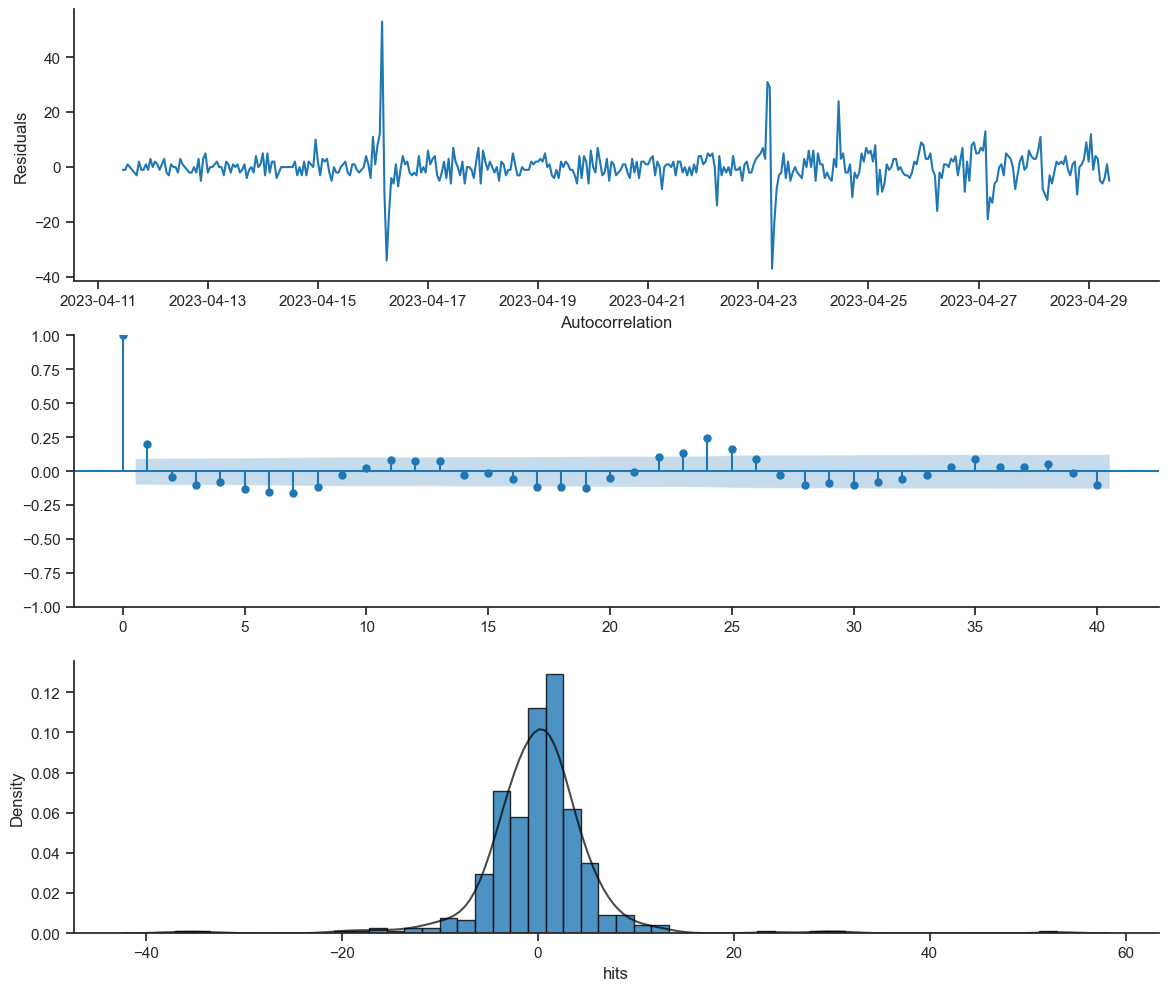

In [60]:
diagnostic(bp_resid[1:])
plt.show()

#### Forecast of Business Analytics - Auto ARIMA with log transformation of time series

In [61]:
ba_h = int(observations.loc['Business Analytics','Test Obs']) #forecast horizon
ba_train = data.loc[data['keyword'] == 'Business Analytics', 'hits'].head(-(observations.loc['Business Analytics','Test Obs']))

#model 
log_train = np.log(ba_train) 
log_arima = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 
ba_resid = (log_train-log_arima.fittedvalues()) # residuals

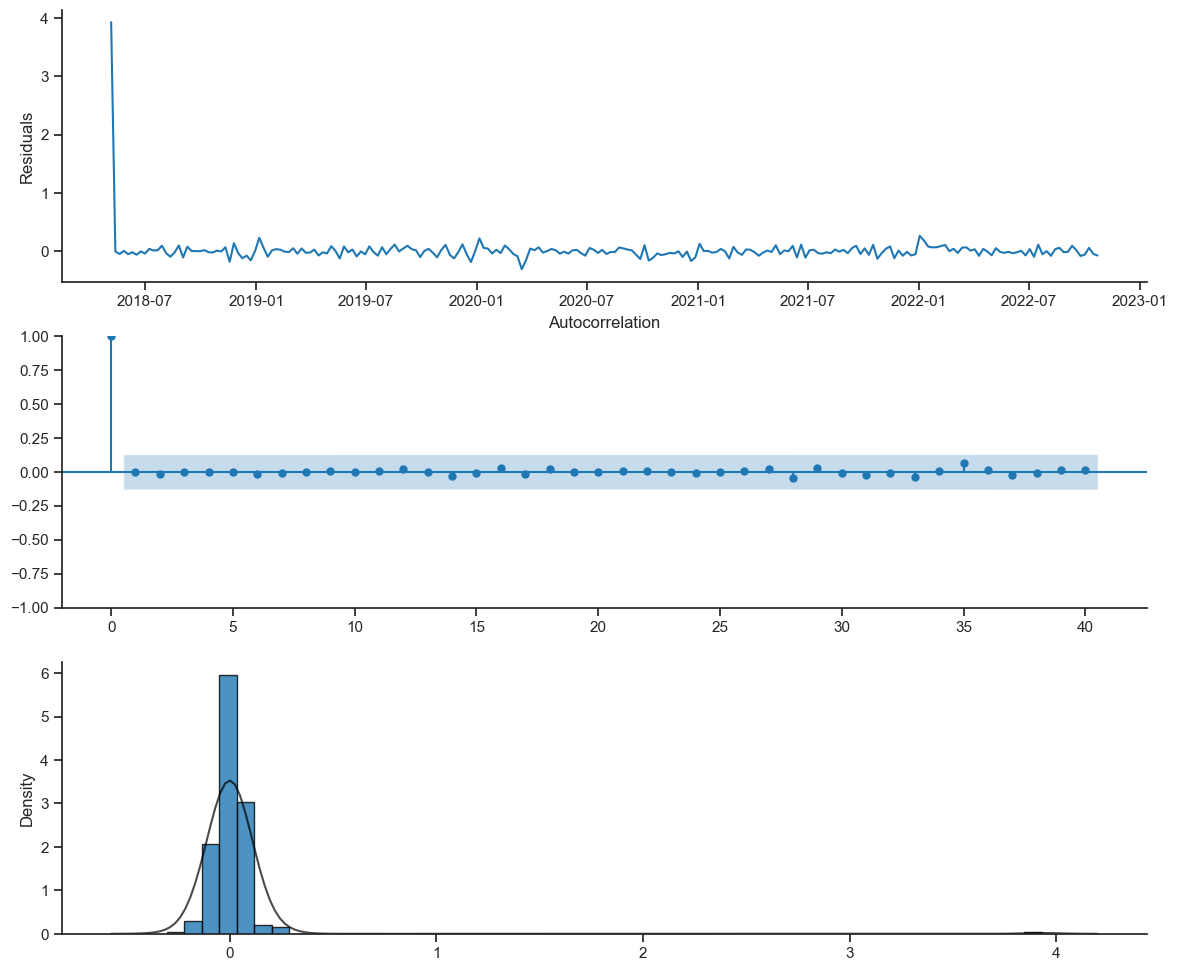

In [62]:
diagnostic(ba_resid) 
plt.show()

#### Forecast of COVID - Random Walk 

In [63]:
cov_h = int(observations.loc['COVID','Test Obs']) #forecast horizon
cov_train = data.loc[data['keyword'] == 'COVID', 'hits'].head(-(observations.loc['COVID','Test Obs']))

cov_resid=cov_train-cov_train.shift(1) # the shift lags the series by one period

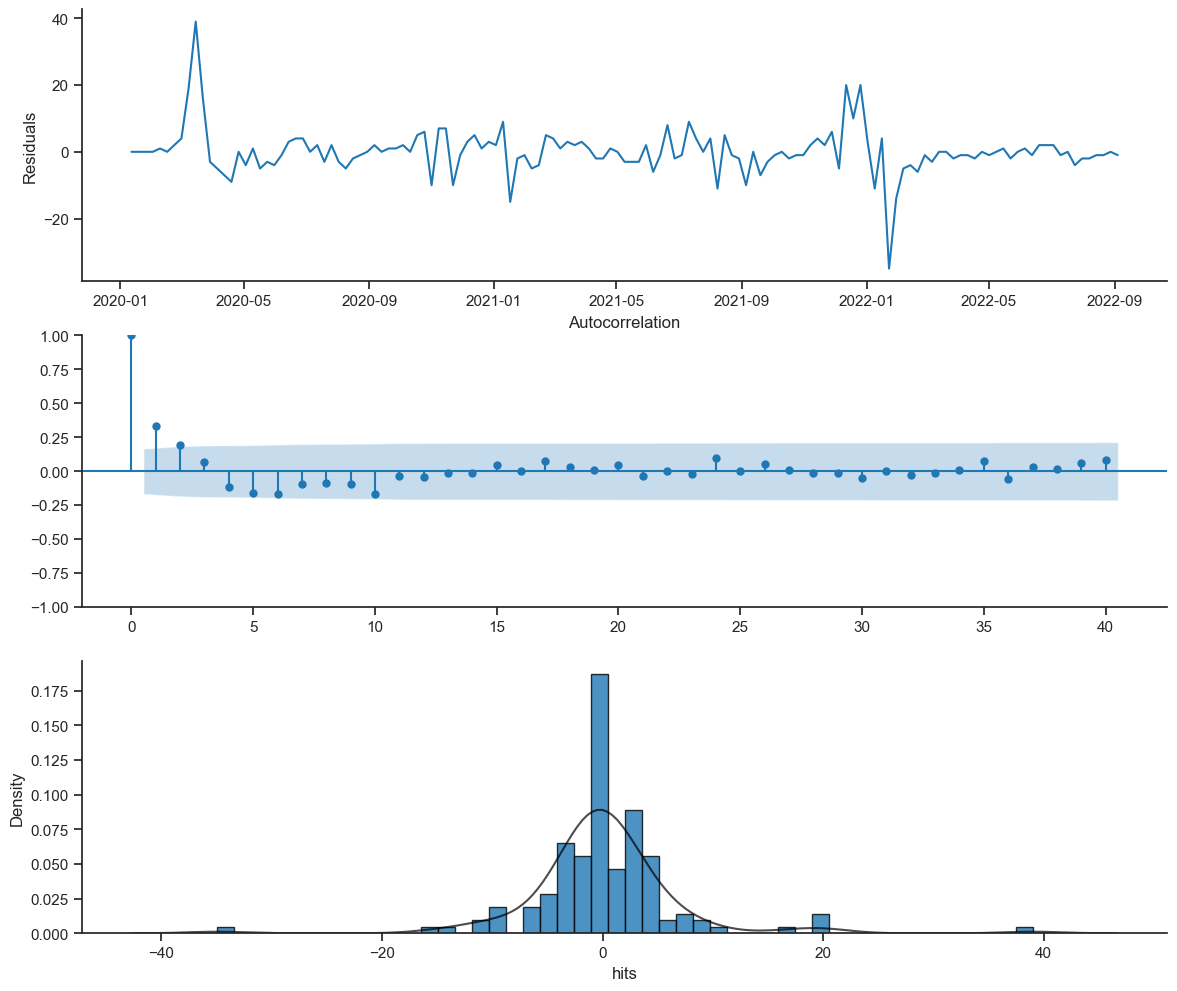

In [64]:
diagnostic(cov_resid[1:])
plt.show()

#### Forecast of ChatGPT - Seasonal Random Walk 

In [65]:
gpt_h = int(observations.loc['ChatGPT','Test Obs']) #forecast horizon
gpt_train = data.loc[data['keyword'] == 'ChatGPT', 'hits'].head(-(observations.loc['ChatGPT','Test Obs']))

gpt_resid = gpt_train-gpt_train.shift(7) # the shift lags the series by a seasonal cycle

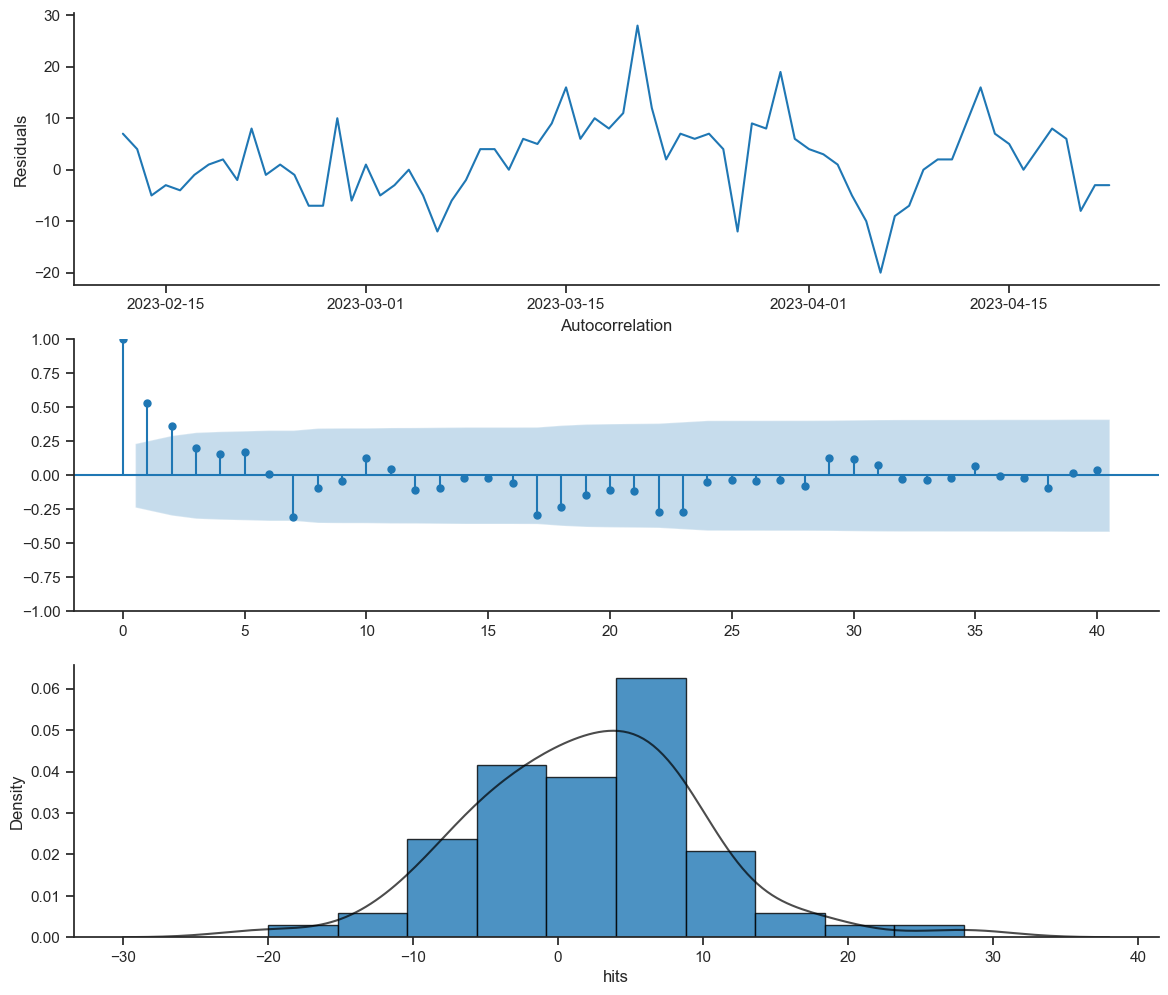

In [66]:
diagnostic(gpt_resid[7:])
plt.show()

#### Forecast of Lazarbeam - Multiplicative Holt-Winter model

In [67]:
lb_h = int(observations.loc['Lazarbeam','Test Obs']) #forecast horizon
lb_train = data.loc[data['keyword'] == 'Lazarbeam', 'hits'].head(-(observations.loc['Lazarbeam','Test Obs']))

lb_model = forecast.holtwinters(lb_train, additive=False, damped=False, m=6)
lb_model.fit()

lb_resid = (lb_train - lb_model.smooth()) #change the model

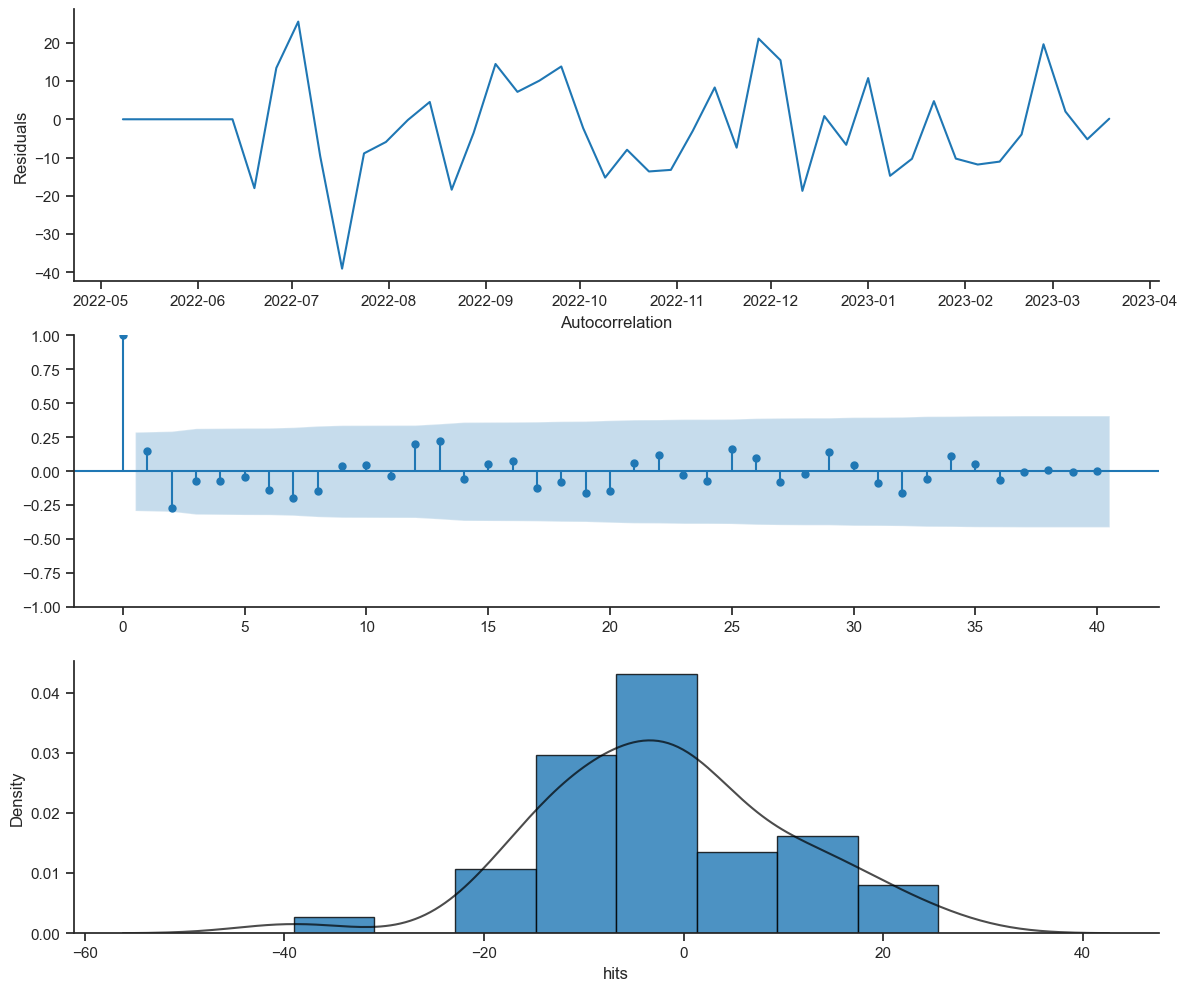

In [68]:
diagnostic(lb_resid)
plt.show()

#### Forecast of MrBeast - Auto ARIMA with log transformation of time series

In [69]:
mb_h = int(observations.loc['MrBeast','Test Obs']) #forecast horizon
mb_train = data.loc[data['keyword'] == 'MrBeast', 'hits'].head(-(observations.loc['MrBeast','Test Obs']))

#model 
log_train = np.log(mb_train) 
model = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 
mb_resid = (log_train-model.fittedvalues()) # residuals

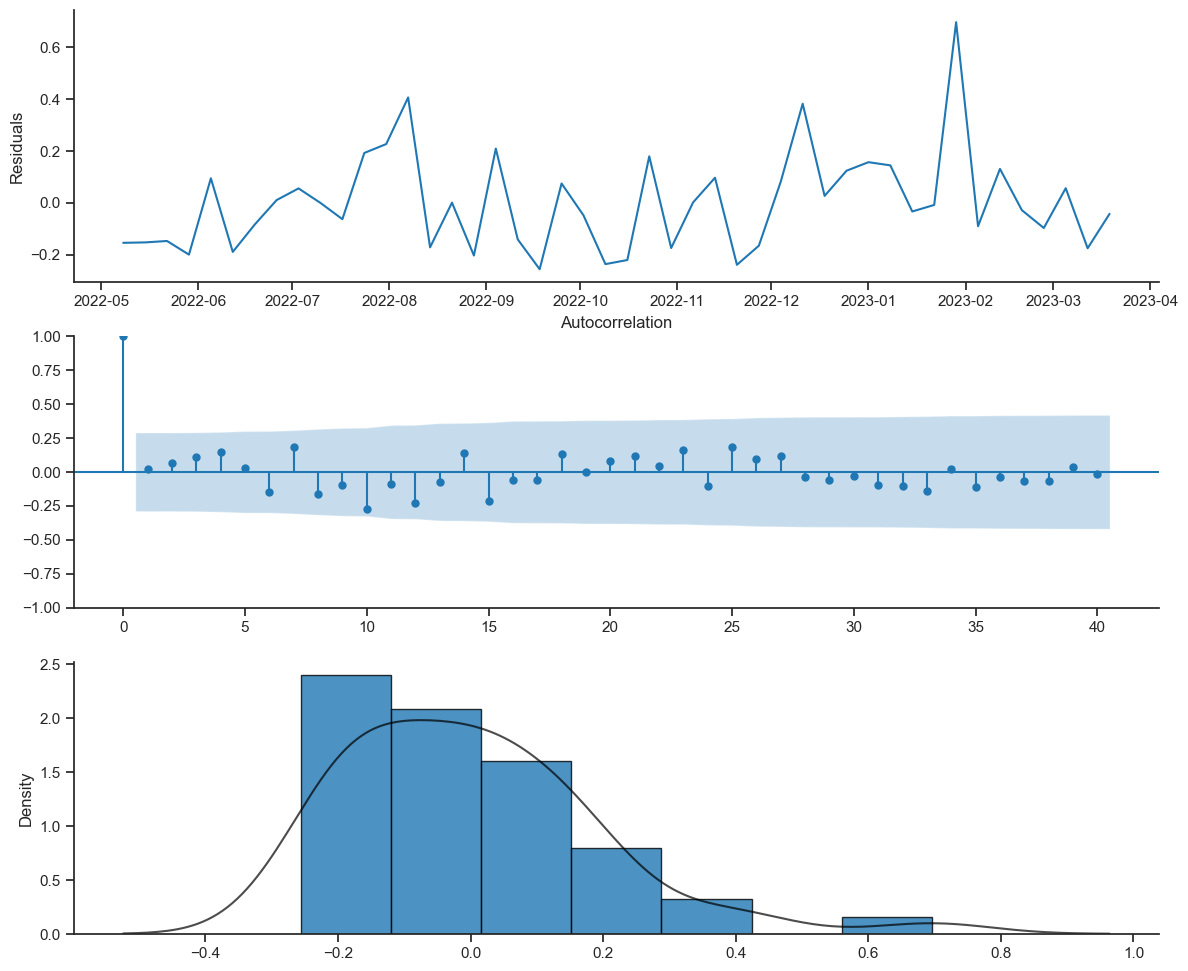

In [70]:
diagnostic(mb_resid)
plt.show()

#### Forecast of University of New South Wales - Auto ARIMA

In [85]:
unsw_h = int(observations.loc['University of New South Wales','Test Obs']) #forecast horizon
unsw_train = data.loc[data['keyword'] == 'University of New South Wales', 'hits'].head(-(observations.loc['University of New South Wales','Test Obs']))

#model 
unsw_model = pm.auto_arima(unsw_train, seasonal=True, m=1) #Auto-ARIMA 
unsw_resid = (unsw_train- unsw_model.fittedvalues()) # residuals

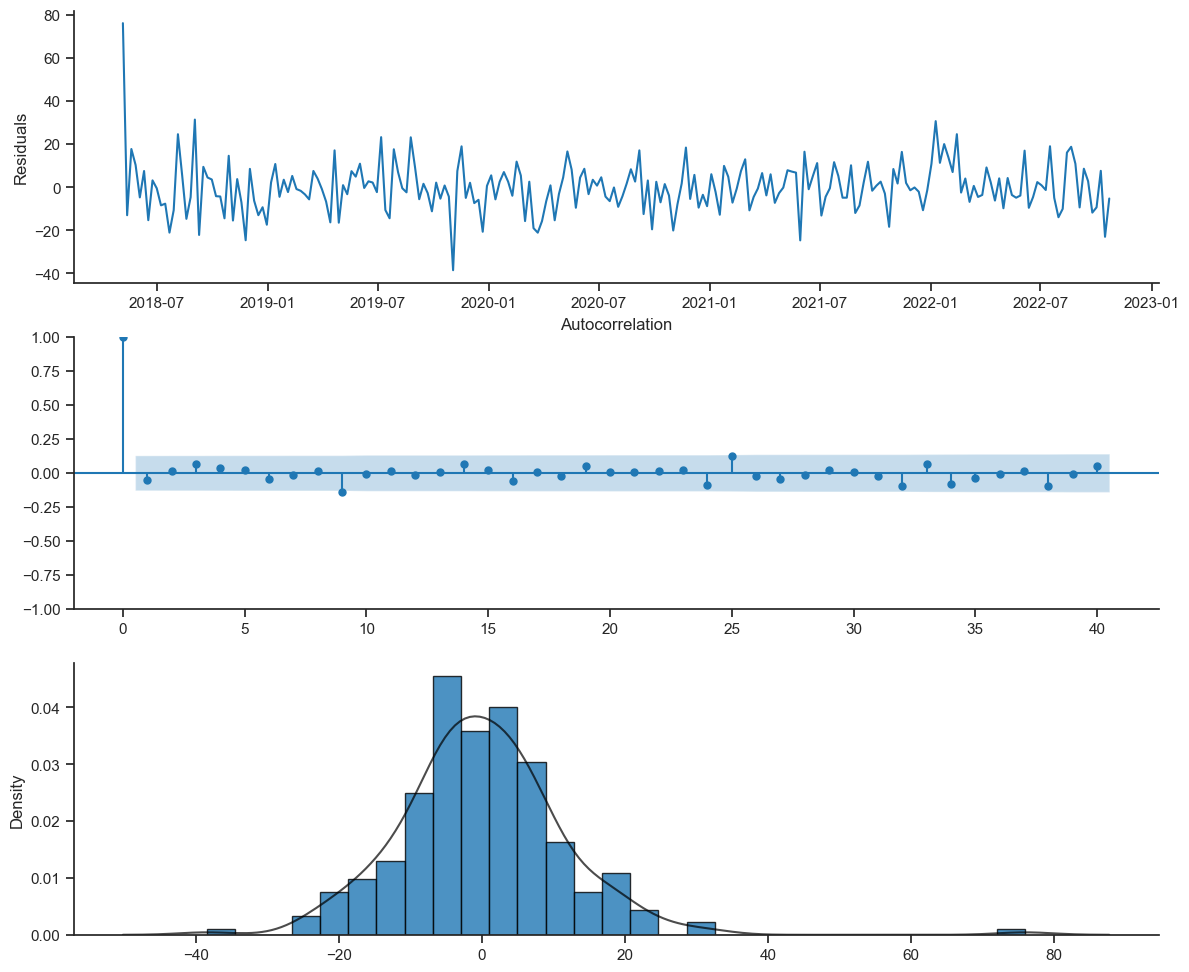

In [86]:
diagnostic(unsw_resid)
plt.show()

#### Forecast of University of Sydney - Auto ARIMA with log transformation of time series

In [87]:
usyd_h = int(observations.loc['University of Sydney','Test Obs']) #forecast horizon
usyd_train = data.loc[data['keyword'] == 'University of Sydney', 'hits'].head(-(observations.loc['University of Sydney','Test Obs']))

#model 
log_train = np.log(usyd_train) 
usyd_model = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 
usyd_resid = (log_train-usyd_model.fittedvalues()) # residuals

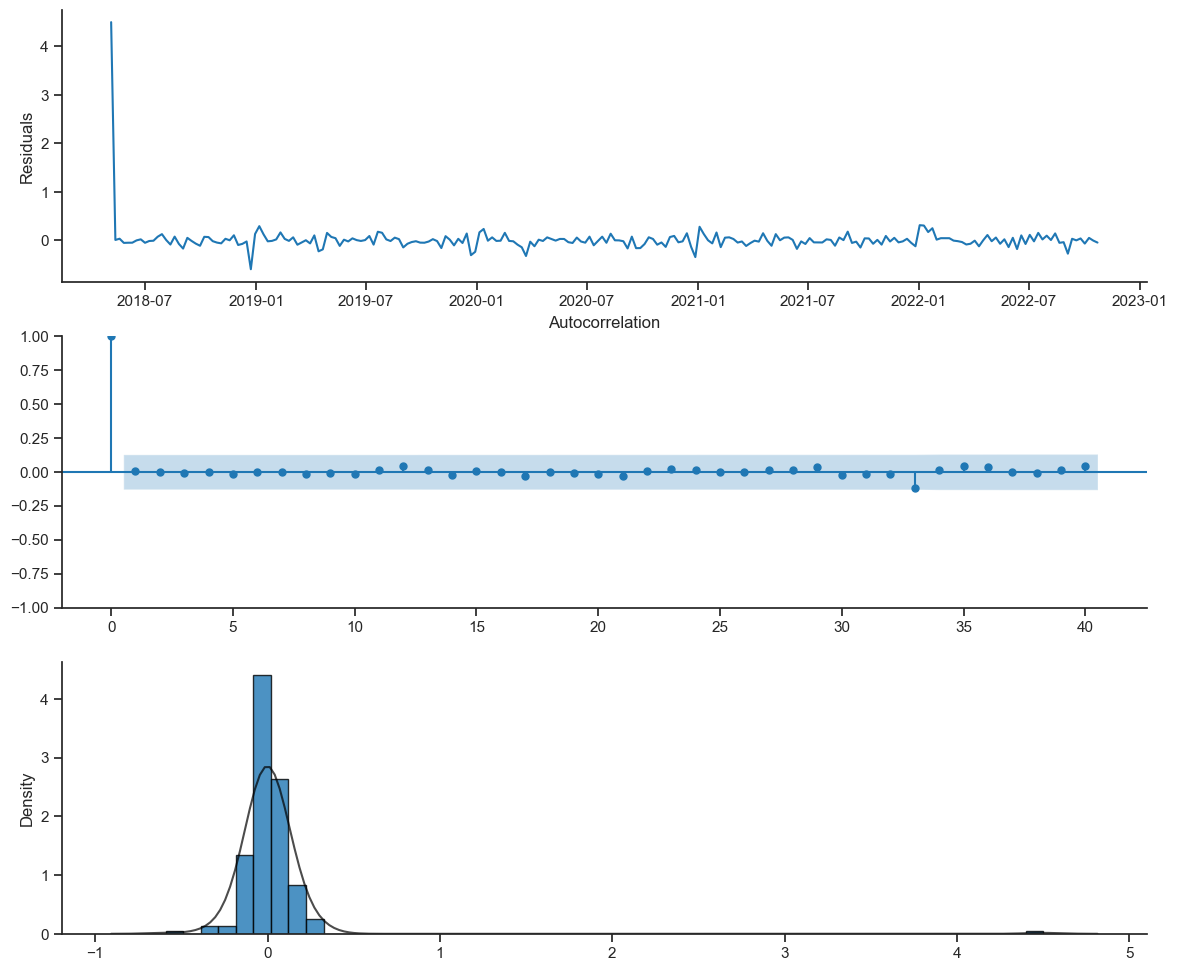

In [88]:
diagnostic(usyd_resid)
plt.show()

#### Forecast of fresh - Seasonal Random Walk 

In [75]:
f_h = int(observations.loc['fresh','Test Obs']) #forecast horizon
f_train = data.loc[data['keyword'] == 'fresh', 'hits'].head(-(observations.loc['fresh','Test Obs']))

f_resid=f_train-f_train.shift(3) # the shift lags the series by a seasonal cycle

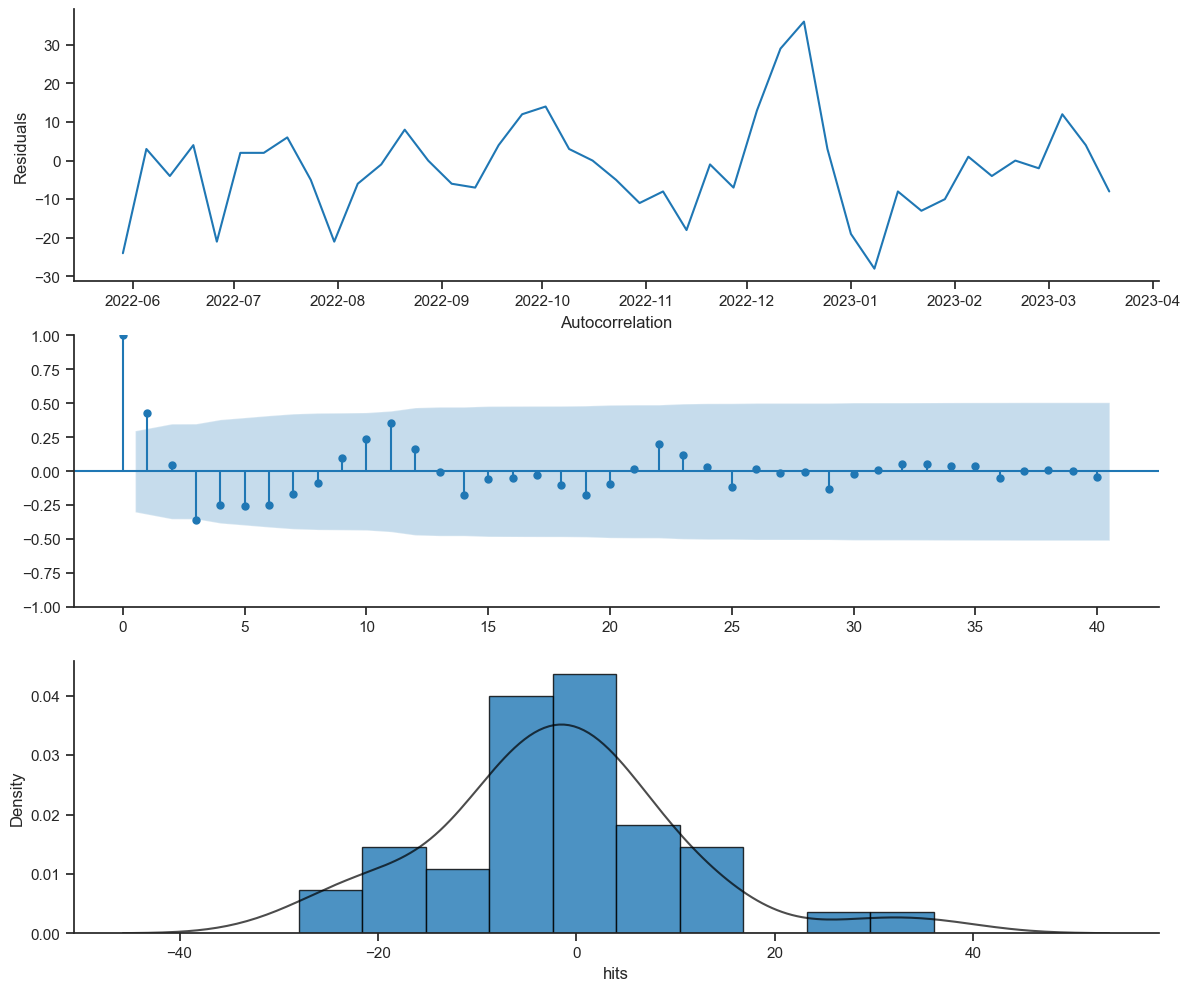

In [76]:
diagnostic(f_resid[3:])
plt.show()

#### Forecast of lachlan - Damped Additive Holt-Winter model

In [77]:
ll_h = int(observations.loc['lachlan','Test Obs']) #forecast horizon
ll_train = data.loc[data['keyword'] == 'lachlan', 'hits'].head(-(observations.loc['lachlan','Test Obs']))

ll_model = forecast.holtwinters(ll_train, additive=True, damped=True, m=2)
ll_model.fit()

ll_resid = ll_train - ll_model.smooth()

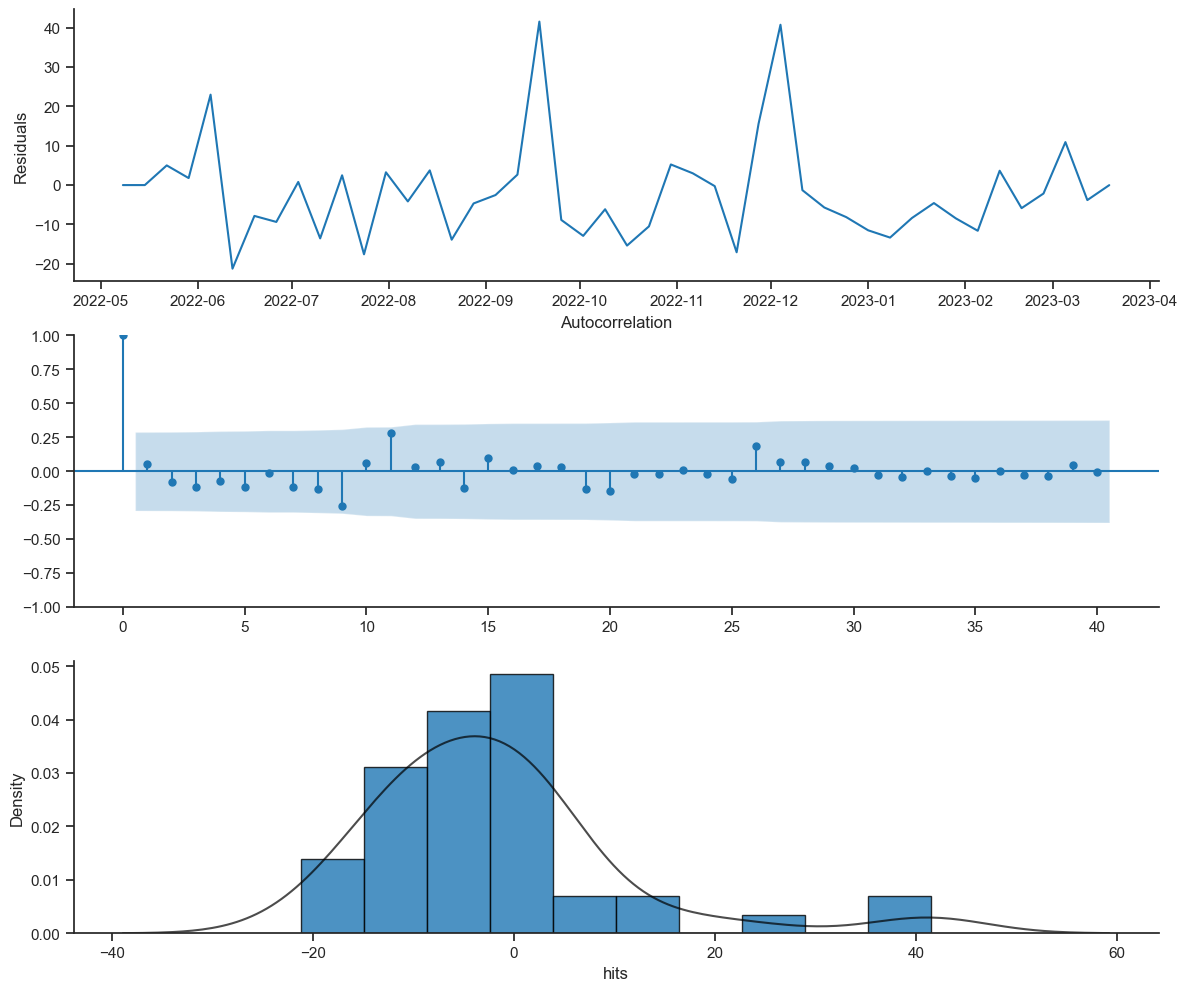

In [78]:
diagnostic(ll_resid)
plt.show()

#### Forecast of loserfruit - Additive Holt-Winter model

In [79]:
lf_h = int(observations.loc['loserfruit','Test Obs']) #forecast horizon
lf_train = data.loc[data['keyword'] == 'loserfruit', 'hits'].head(-(observations.loc['loserfruit','Test Obs']))

lf_model = forecast.holtwinters(lf_train, additive=True, damped=False, m=3)
lf_model.fit()

lf_resid = (lf_train-lf_model.smooth())

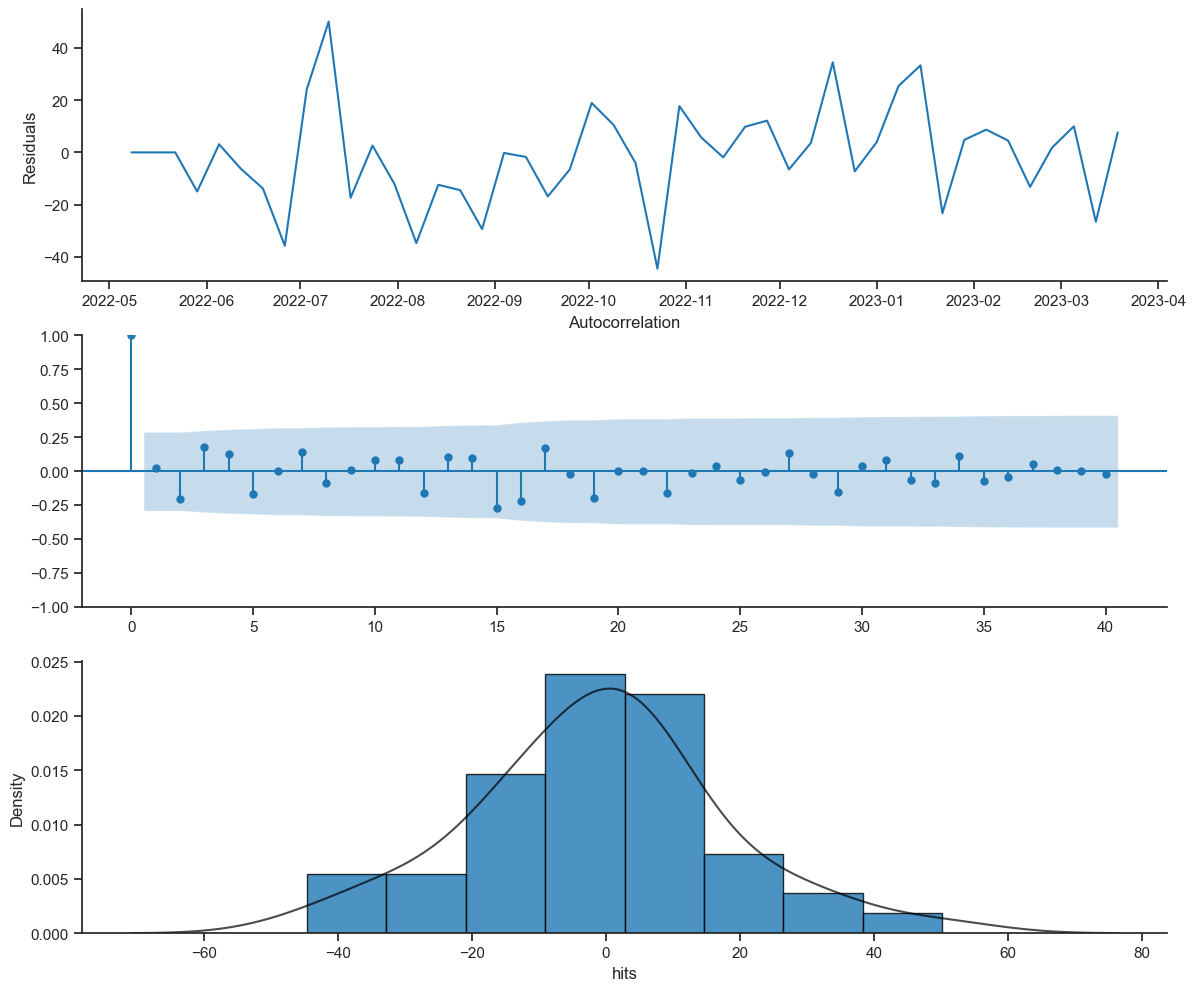

In [80]:
diagnostic(lf_resid)
plt.show()

## Forecast & Results

The function calculated probabilistic forecast for Holt-Winter model is obtained from the forecast.py module. While for ARIMA model, the function that was used for calculate probabilistic forecast was chosen among other potential possibilities in the package however, it is not sure that this function computes the predictive distribution or the distribution of the mean. For the random walk and seasonal random walk model, the interval forecast was calculated manually following the formula in the lecture with the alpha level of 0.5. 

In [81]:
def fanchart(y, forecast, intv1):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)
    with sns.axes_style('ticks'):
        fig, ax= plt.subplots(figsize=(10,5))
        y.plot(color='#D62728', label = "Train set")
        extended.plot(color='black', alpha = 0.5, label='Point forecast', linestyle ='--')
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]), 
                        facecolor='#F58671', lw=0, label = 'Probabilistic forecast')
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    
    return fig, ax

#### Forecast of 5SOS - Auto arima with log transformation of time series

In [82]:
sos_y = data.loc[data['keyword'] == '5SOS', 'hits']
sos_test = data.loc[data['keyword'] == '5SOS', 'hits'].tail(observations.loc['5SOS','Test Obs'])

#model 
log_train = np.log(sos_train) 
log_arima = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log x

In [83]:
#point forecast 
steps_preds = pd.Series(np.exp(log_arima.predict(sos_h)), index = sos_test.index)

#probabilistic forecast
intv1 = pd.DataFrame(log_arima.predict(sos_h, alpha = 0.50, return_conf_int=True)[1], index = sos_test.index) 
intv1=np.exp(intv1)

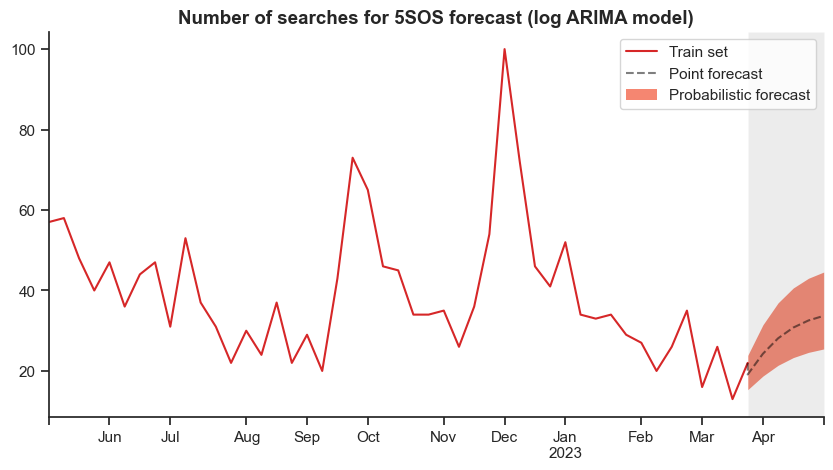

In [91]:
fig, ax = fanchart(sos_y.iloc[:47], steps_preds, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for 5SOS forecast (log ARIMA model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [92]:
#performance 
from sklearn.metrics import mean_absolute_error

#in-sample fit error 
fitted_value = np.exp(log_arima.fittedvalues())
train_mae = mean_absolute_error(fitted_value, sos_train)

#out-of-sample error 
test_mae = mean_absolute_error(steps_preds, sos_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 9.606
The out-of-sample MAE: 3.824


#### Forecast of Blackpink - Random walk 

In [93]:
bp_y = data.loc[data['keyword'] == 'Blackpink', 'hits']
bp_test = data.loc[data['keyword'] == 'Blackpink', 'hits'].tail(observations.loc['Blackpink','Test Obs'])
train_obs = observations.loc['Blackpink','Train Obs']

In [94]:
#point forecast
bp_pred = pd.Series(np.repeat(bp_train.iloc[-1], bp_h), index= bp_test.index) # the forecast repeats the last observed values h times

#probabilistic forecast
bp_sigma = bp_resid.std() #standard deviation of errors 
round(bp_sigma,3)
intv1 = pd.concat([bp_pred-stats.norm.ppf(0.75)*bp_sigma*np.sqrt(np.arange(1,bp_h+1)),
                   bp_pred+stats.norm.ppf(0.75)*bp_sigma*np.sqrt(np.arange(1,bp_h+1))], axis=1) #probabilistic forecast with 75% quantile and 25% quantile


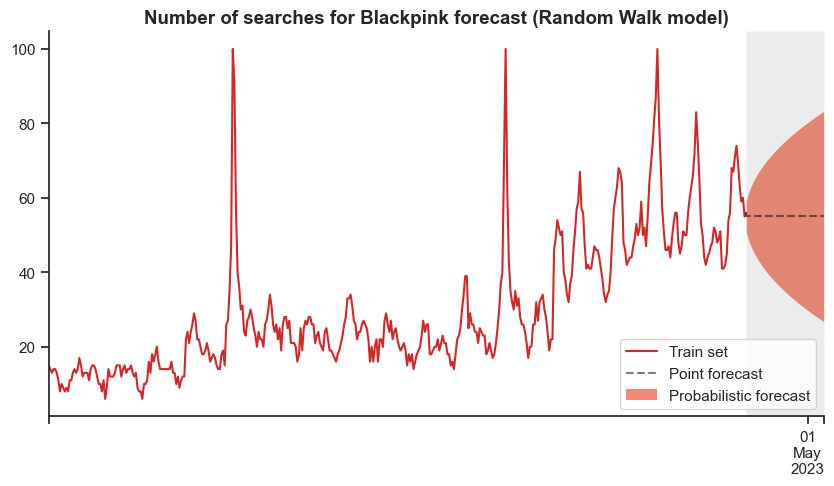

In [95]:
fig, ax =fanchart(bp_y.iloc[:train_obs + 1], bp_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for Blackpink forecast (Random Walk model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [96]:
#in-sample fit error 
bp_fitted_value = bp_train.shift(1)
train_mae = mean_absolute_error(bp_fitted_value[1:], bp_train[1:])

#out-of-sample error 
test_mae = mean_absolute_error(bp_pred, bp_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 3.49
The out-of-sample MAE: 8.816


#### Forecast of Business Analytics - Auto ARIMA with log transformation of time series

In [97]:
ba_y = data.loc[data['keyword'] == 'Business Analytics', 'hits']
ba_test = data.loc[data['keyword'] == 'Business Analytics', 'hits'].tail(observations.loc['Business Analytics','Test Obs'])
train_obs = observations.loc['Business Analytics','Train Obs']

#model 
log_train = np.log(ba_train) 
ba_model = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 

In [98]:
#point forecast 
ba_preds = pd.Series(np.exp(ba_model.predict(ba_h)), index = ba_test.index)

#probabilistic forecast
intv1 = pd.DataFrame(ba_model.predict(ba_h, alpha = 0.50, return_conf_int=True)[1], index = ba_test.index) 
intv1=np.exp(intv1)

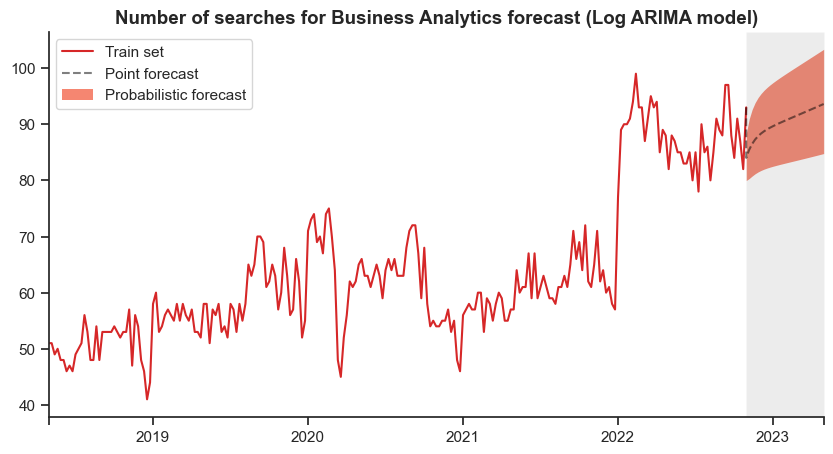

In [99]:
fig, ax =fanchart(ba_y.iloc[:train_obs + 1], ba_preds, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for Business Analytics forecast (Log ARIMA model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [100]:
#in-sample fit error 
ba_fitted_value = np.exp(ba_model.fittedvalues())
train_mae = mean_absolute_error(ba_fitted_value, ba_train)

#out-of-sample error 
test_mae = mean_absolute_error(ba_preds, ba_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 3.69
The out-of-sample MAE: 6.008


#### Forecast of COVID - Random Walk 

In [101]:
cov_y = data.loc[data['keyword'] == 'COVID', 'hits']
cov_test = data.loc[data['keyword'] == 'COVID', 'hits'].tail(observations.loc['COVID','Test Obs'])
train_obs = observations.loc['COVID','Train Obs']

In [102]:
#point forecast
cov_pred = pd.Series(np.repeat(cov_train.iloc[-1], cov_h), index= cov_test.index) # the forecast repeats the last observed values h times

#probabilistic forecast
cov_sigma = cov_resid.std() #standard deviation of errors 
round(cov_sigma,3)
intv1 = pd.concat([cov_pred-stats.norm.ppf(0.75)*cov_sigma*np.sqrt(np.arange(1,cov_h+1)),
                   cov_pred+stats.norm.ppf(0.75)*cov_sigma*np.sqrt(np.arange(1,cov_h+1))], axis=1) 


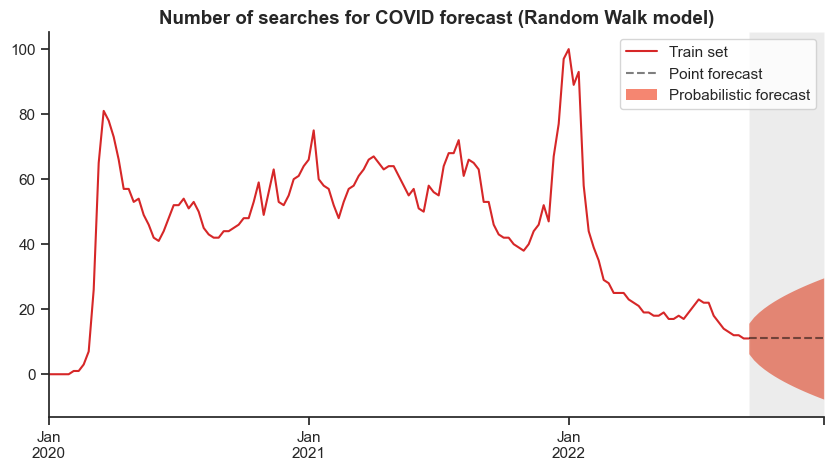

In [103]:
fig, ax =fanchart(cov_y.iloc[:train_obs + 1], cov_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for COVID forecast (Random Walk model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [104]:
#in-sample fit error 
cov_fitted_value = cov_train.shift(1)
train_mae = mean_absolute_error(cov_fitted_value[1:], cov_train[1:])

#out-of-sample error 
test_mae = mean_absolute_error(cov_pred, cov_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 3.978
The out-of-sample MAE: 0.875


#### Forecast of ChatGPT - Seasonal Random Walk 

In [105]:
gpt_y = data.loc[data['keyword'] == 'ChatGPT', 'hits']
gpt_test = data.loc[data['keyword'] == 'ChatGPT', 'hits'].tail(observations.loc['ChatGPT','Test Obs'])
train_obs = observations.loc['ChatGPT','Train Obs']

In [106]:
#point forecast 
gpt_pred = []
start = observations.loc['ChatGPT','Train Obs']
for i in range(start, len(gpt_y)): 
    gpt_pred.append(gpt_y.iloc[i - 7]) #seasonal walk forecast
gpt_pred = pd.Series(gpt_pred, index= gpt_test.index)
    
#probabilistic forecast 
gpt_sigma = gpt_resid.std() #standard deviation of errors 
round(gpt_sigma,3)
intv1 = pd.concat([gpt_pred-stats.norm.ppf(0.75)*gpt_sigma*np.sqrt(np.arange(1,gpt_h+1)),
                   gpt_pred+stats.norm.ppf(0.75)*gpt_sigma*np.sqrt(np.arange(1,gpt_h+1))], axis=1) #50%

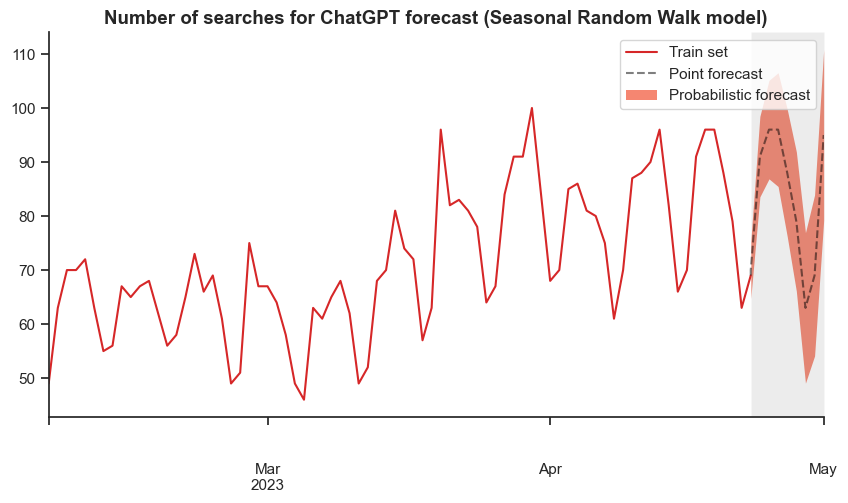

In [107]:
fig, ax =fanchart(gpt_y.iloc[:train_obs + 1], gpt_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for ChatGPT forecast (Seasonal Random Walk model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [108]:
#in-sample fit error 
gpt_fitted_value = gpt_train.shift(7)
train_mae = mean_absolute_error(gpt_fitted_value[7:], gpt_train[7:])

#out-of-sample error 
test_mae = mean_absolute_error(gpt_pred, gpt_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 6.214
The out-of-sample MAE: 4.111


#### Forecast of Lazarbeam - Multiplicative Holt-Winter model

In [109]:
lb_y = data.loc[data['keyword'] == 'Lazarbeam', 'hits'] 
lb_test = data.loc[data['keyword'] == 'Lazarbeam', 'hits'].tail(observations.loc['Lazarbeam','Test Obs'])
train_obs = observations.loc['Lazarbeam','Train Obs']

In [110]:
#point forecast
lb_pred = pd.Series(lb_model.forecast(lb_h), index=lb_test.index)

#probabilistic forecast
intv1=pd.DataFrame(lb_model.intervalforecast(lb_h, level=.50), index=lb_test.index)

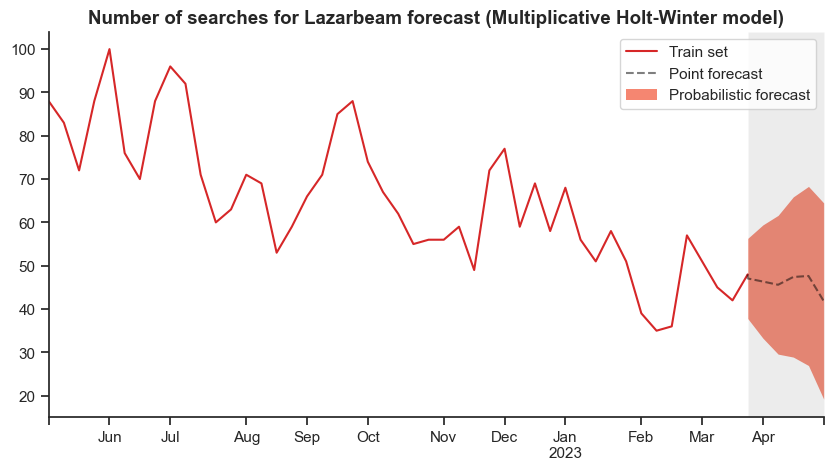

In [111]:
fig, ax =fanchart(lb_y.iloc[:train_obs + 1], lb_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for Lazarbeam forecast (Multiplicative Holt-Winter model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [112]:
#in-sample fit error 
lb_fitted_value = lb_model.smooth()
train_mae = mean_absolute_error(lb_fitted_value, lb_train)

#out-of-sample error 
test_mae = mean_absolute_error(lb_pred, lb_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 9.377
The out-of-sample MAE: 5.75


#### Forecast of MrBeast - Auto ARIMA with log transformation of time series

In [113]:
mb_y = data.loc[data['keyword'] == 'MrBeast', 'hits']
mb_test = data.loc[data['keyword'] == 'MrBeast', 'hits'].tail(observations.loc['MrBeast','Test Obs'])
train_obs = observations.loc['MrBeast','Train Obs']

#model 
log_train = np.log(mb_train) 
mb_model = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 

In [114]:
#point forecast 
mb_preds = pd.Series(np.exp(mb_model.predict(mb_h)), index = mb_test.index)

#probabilistic forecast
intv1 = pd.DataFrame(mb_model.predict(mb_h, alpha = 0.50, return_conf_int=True)[1], index = mb_test.index) 
intv1=np.exp(intv1)

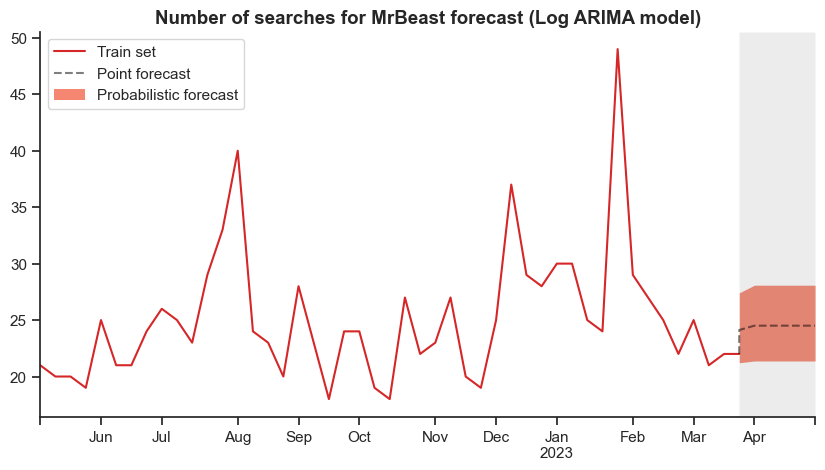

In [115]:
fig, ax =fanchart(mb_y.iloc[:train_obs + 1], mb_preds, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for MrBeast forecast (Log ARIMA model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [116]:
#in-sample fit error 
mb_fitted_value = mb_model.fittedvalues()
train_mae = mean_absolute_error(mb_fitted_value, mb_train)

#out-of-sample error 
test_mae = mean_absolute_error(mb_preds, mb_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 21.887
The out-of-sample MAE: 20.6


#### Forecast of University of New South Wales - Auto ARIMA

In [117]:
unsw_y = data.loc[data['keyword'] == 'University of New South Wales', 'hits']
unsw_test = data.loc[data['keyword'] == 'University of New South Wales', 'hits'].tail(observations.loc['University of New South Wales','Test Obs'])
train_obs = observations.loc['University of New South Wales','Train Obs']

#model 
unsw_model = pm.auto_arima(unsw_train, seasonal=True, m=1) #Auto-ARIMA

In [118]:
#point forecast 
unsw_preds = pd.Series(unsw_model.predict(unsw_h), index = unsw_test.index)

#probabilistic forecast
intv1 = pd.DataFrame(unsw_model.predict(unsw_h, alpha = 0.50, return_conf_int=True)[1], index = unsw_test.index) #50%

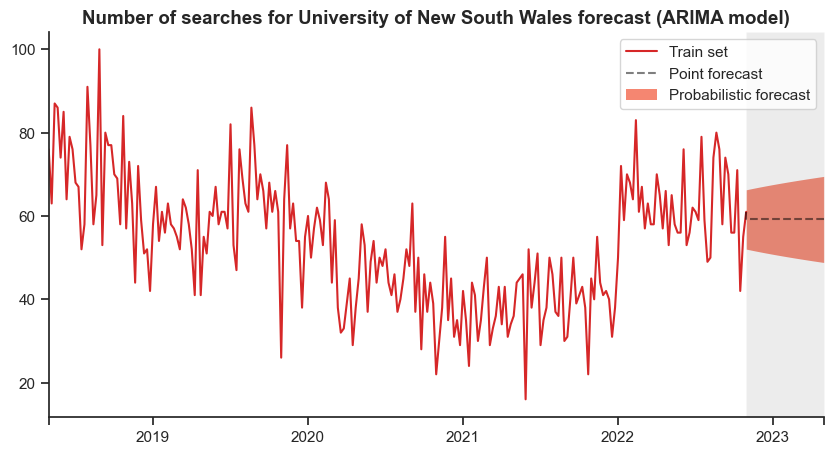

In [119]:
fig, ax =fanchart(unsw_y.iloc[:train_obs + 1], unsw_preds, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for University of New South Wales forecast (ARIMA model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [120]:
#in-sample fit error 
unsw_fitted_value = unsw_model.fittedvalues()
train_mae = mean_absolute_error(unsw_fitted_value, unsw_train)

#out-of-sample error 
test_mae = mean_absolute_error(unsw_preds, unsw_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 8.481
The out-of-sample MAE: 10.339


#### Forecast of University of Sydney - Auto ARIMA with log transformation of time series

In [121]:
usyd_y = data.loc[data['keyword'] == 'University of Sydney', 'hits']
usyd_test = data.loc[data['keyword'] == 'University of Sydney', 'hits'].tail(observations.loc['University of Sydney','Test Obs'])
train_obs = observations.loc['University of Sydney','Train Obs']

#model 
log_train = np.log(usyd_train) 
usyd_model = pm.auto_arima(log_train, seasonal=True, m=1) #Auto-ARIMA with log 

In [122]:
#point forecast 
usyd_preds = pd.Series(np.exp(usyd_model.predict(usyd_h)), index = usyd_test.index)

#probabilistic forecast
intv1 = pd.DataFrame(usyd_model.predict(usyd_h, alpha = 0.50, return_conf_int=True)[1], index = usyd_test.index) 
intv1 = np.exp(intv1)

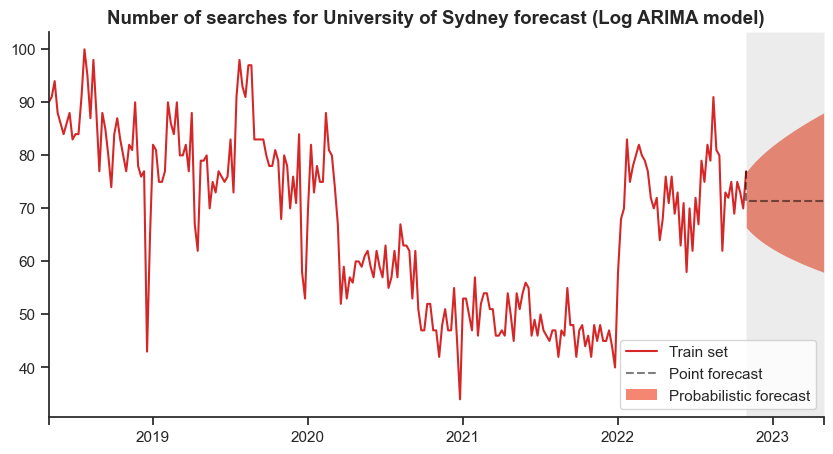

In [123]:
fig, ax =fanchart(usyd_y.iloc[:train_obs + 1], usyd_preds, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for University of Sydney forecast (Log ARIMA model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [124]:
#in-sample fit error 
usyd_fitted_value = usyd_model.fittedvalues()
train_mae = mean_absolute_error(usyd_fitted_value, usyd_train)

#out-of-sample error 
test_mae = mean_absolute_error(usyd_preds, usyd_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 63.325
The out-of-sample MAE: 9.82


#### Forecast of fresh - Seasonal Random Walk 

In [125]:
f_y = data.loc[data['keyword'] == 'fresh', 'hits']
f_test = data.loc[data['keyword'] == 'fresh', 'hits'].tail(observations.loc['fresh','Test Obs'])
train_obs = observations.loc['fresh','Train Obs']

In [126]:
#point forecast 
f_pred = []
start = observations.loc['fresh','Train Obs']
for i in range(start, len(f_y)): 
    f_pred.append(f_y.iloc[i - 3]) #seasonal walk forecast
f_pred = pd.Series(f_pred, index= f_test.index)
    
#probabilistic forecast 
f_sigma = f_resid.std() #standard deviation of errors 
round(f_sigma,3)
intv1 = pd.concat([f_pred-stats.norm.ppf(0.75)*f_sigma*np.sqrt(np.arange(1,f_h+1)),
                   f_pred+stats.norm.ppf(0.75)*f_sigma*np.sqrt(np.arange(1,f_h+1))], axis=1) #alpha = 0.5

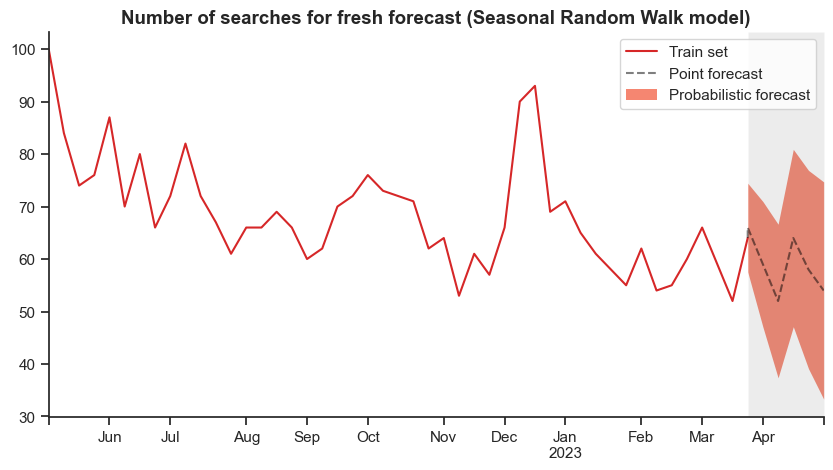

In [127]:
fig, ax =fanchart(f_y.iloc[:train_obs + 1], f_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for fresh forecast (Seasonal Random Walk model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [128]:
#in-sample fit error 
f_fitted_value = f_train.shift(3)
train_mae = mean_absolute_error(f_fitted_value[3:], f_train[3:])

#out-of-sample error 
test_mae = mean_absolute_error(f_pred, f_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 9.14
The out-of-sample MAE: 3.333


#### Forecast of lachlan - Damped Additive Holt-Winter model

In [129]:
ll_y = data.loc[data['keyword'] == 'lachlan', 'hits']
ll_test = data.loc[data['keyword'] == 'lachlan', 'hits'].tail(observations.loc['lachlan','Test Obs'])
train_obs = observations.loc['lachlan','Train Obs']

In [130]:
#point forecast
ll_pred = pd.Series(ll_model.forecast(ll_h), index=ll_test.index)

#probabilistic forecast
intv1=pd.DataFrame(ll_model.intervalforecast(ll_h, level=.50), index=ll_test.index)

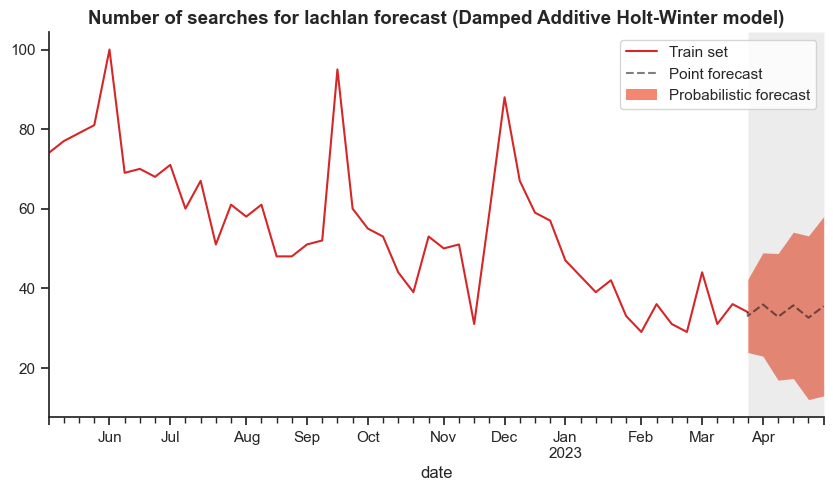

In [131]:
fanchart(ll_y.iloc[:train_obs + 1], ll_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for lachlan forecast (Damped Additive Holt-Winter model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [132]:
#in-sample fit error 
ll_fitted_value = ll_model.smooth()
train_mae = mean_absolute_error(ll_fitted_value, ll_train)

#out-of-sample error 
test_mae = mean_absolute_error(ll_pred, ll_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 9.002
The out-of-sample MAE: 3.649


#### Forecast of loserfruit - Additive Holt-Winter model

In [133]:
lf_y = data.loc[data['keyword'] == 'loserfruit', 'hits']
lf_test = data.loc[data['keyword'] == 'loserfruit', 'hits'].tail(observations.loc['loserfruit','Test Obs'])
train_obs = observations.loc['loserfruit','Train Obs']

In [134]:
#point forecast
lf_pred = pd.Series(lf_model.forecast(lf_h), index=lf_test.index)

#probabilistic forecast
intv1=pd.DataFrame(lf_model.intervalforecast(lf_h, level=.50), index=lf_test.index)

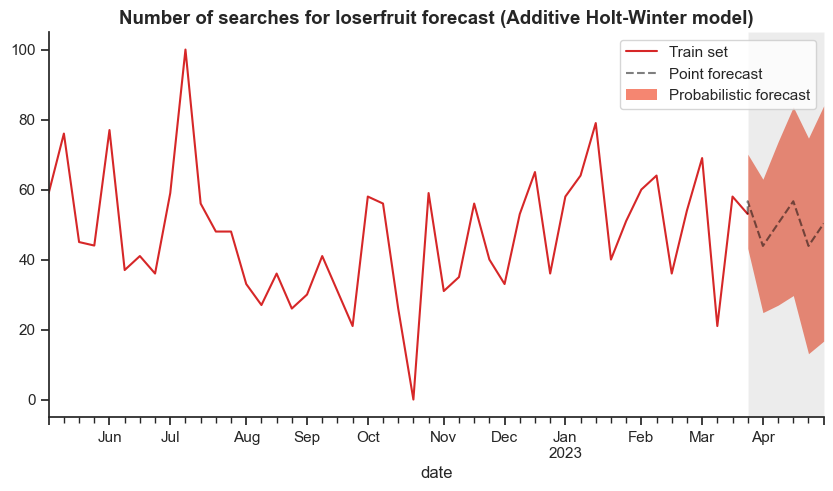

In [135]:
fanchart(lf_y.iloc[:train_obs + 1], lf_pred, intv1)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Number of searches for loserfruit forecast (Additive Holt-Winter model)', fontsize=13.5, fontweight='bold')
plt.legend()
sns.despine()
plt.show()

In [136]:
#in-sample fit error 
lf_fitted_value = lf_model.smooth()
train_mae = mean_absolute_error(lf_fitted_value, lf_train)

#out-of-sample error 
test_mae = mean_absolute_error(lf_pred, lf_test)

print('The in-sample MAE: {}'.format(round(train_mae,3)))
print('The out-of-sample MAE: {}'.format(round(test_mae,3)))

The in-sample MAE: 13.88
The out-of-sample MAE: 7.749
